In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import gc

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)



In [8]:

train_dtypes = {
    'store_nbr': 'int8',
    'item_nbr': 'int32', 
    'unit_sales': 'float32',
    'onpromotion': 'boolean'
}

try:
    train = pd.read_csv('train.csv', dtype=train_dtypes, parse_dates=['date'])
    print(f"Loaded train: {train.shape}")
except MemoryError:
    print("Memory error - loading in chunks...")
    
    def load_train_chunks(chunk_size=100000, max_rows=2000000):
        chunks = []
        rows_read = 0
        
        try:
            for chunk in pd.read_csv('train.csv', dtype=train_dtypes, 
                                   parse_dates=['date'], chunksize=chunk_size):
                chunks.append(chunk)
                rows_read += len(chunk)
                
                if rows_read >= max_rows:
                    break
            
            return pd.concat(chunks, ignore_index=True)
        
        except MemoryError:
            if chunks:
                return pd.concat(chunks[:5], ignore_index=True)
            else:
                return pd.read_csv('train.csv', dtype=train_dtypes, 
                                 parse_dates=['date'], nrows=100000)
    
    train = load_train_chunks()

test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
stores = pd.read_csv('stores.csv')
items = pd.read_csv('items.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')
transactions = pd.read_csv('transactions.csv')




Loaded train: (125497040, 6)


In [3]:
def memory_usage_mb(df):
    return round(df.memory_usage(deep=True).sum() / 1024**2, 2)

def missing_data_summary(df, name):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'Column': df.columns,
        'Missing': missing.values,
        'Percent': missing_percent.values
    }).sort_values('Percent', ascending=False)
    return missing_df[missing_df['Missing'] > 0]

## 2. Basic Statistics

In [4]:
datasets_info = {
    'Train': train,
    'Test': test,
    'Sample Sub': sample_submission,
    'Stores': stores,
    'Items': items,
    'Oil': oil,
    'Holidays': holidays,
    'Transactions': transactions
}

print("Dataset Overview:")
print("-" * 40)

for name, df in datasets_info.items():
    if df is not None:
        rows, cols = df.shape
        memory = memory_usage_mb(df)
        print(f"{name:12}: {rows:>8,} √ó {cols:>2} | {memory:>6} MB")

Dataset Overview:
----------------------------------------
Train       : 125,497,040 √ó  6 | 3231.45 MB
Test        : 3,370,464 √ó  5 |  270.0 MB
Sample Sub  : 3,370,464 √ó  2 |  51.43 MB
Stores      :       54 √ó  5 |   0.01 MB
Items       :    4,100 √ó  4 |   0.32 MB
Oil         :    1,218 √ó  2 |   0.08 MB
Holidays    :      350 √ó  6 |    0.1 MB
Transactions:   83,488 √ó  3 |   5.97 MB
Test        : 3,370,464 √ó  5 |  270.0 MB
Sample Sub  : 3,370,464 √ó  2 |  51.43 MB
Stores      :       54 √ó  5 |   0.01 MB
Items       :    4,100 √ó  4 |   0.32 MB
Oil         :    1,218 √ó  2 |   0.08 MB
Holidays    :      350 √ó  6 |    0.1 MB
Transactions:   83,488 √ó  3 |   5.97 MB


ANALIZA METADANYCH SKLEP√ìW:
Kolumny stores.csv: ['store_nbr', 'city', 'state', 'type', 'cluster']
Liczba sklep√≥w: 54

TYPY SKLEP√ìW:
   D: 18 (33.3%)
   C: 15 (27.8%)
   A: 9 (16.7%)
   B: 8 (14.8%)
   E: 4 (7.4%)

STANY (TOP 10):
   Pichincha: 19 (35.2%)
   Guayas: 11 (20.4%)
   Azuay: 3 (5.6%)
   Santo Domingo de los Tsachilas: 3 (5.6%)
   Manabi: 3 (5.6%)
   Los Rios: 2 (3.7%)
   Cotopaxi: 2 (3.7%)
   Tungurahua: 2 (3.7%)
   El Oro: 2 (3.7%)
   Bolivar: 1 (1.9%)

MIASTA (TOP 10):
   Quito: 18 (33.3%)
   Guayaquil: 8 (14.8%)
   Cuenca: 3 (5.6%)
   Santo Domingo: 3 (5.6%)
   Latacunga: 2 (3.7%)
   Machala: 2 (3.7%)
   Manta: 2 (3.7%)
   Ambato: 2 (3.7%)
   Cayambe: 1 (1.9%)
   Riobamba: 1 (1.9%)

KLASTRY:
   Liczba klastr√≥w: 17
   Zakres: 1 - 17


ANALIZA METADANYCH SKLEP√ìW:
Kolumny stores.csv: ['store_nbr', 'city', 'state', 'type', 'cluster']
Liczba sklep√≥w: 54

TYPY SKLEP√ìW:
   D: 18 (33.3%)
   C: 15 (27.8%)
   A: 9 (16.7%)
   B: 8 (14.8%)
   E: 4 (7.4%)

STANY (TOP 10):
   Pichincha: 19 (35.2%)
   Guayas: 11 (20.4%)
   Azuay: 3 (5.6%)
   Santo Domingo de los Tsachilas: 3 (5.6%)
   Manabi: 3 (5.6%)
   Los Rios: 2 (3.7%)
   Cotopaxi: 2 (3.7%)
   Tungurahua: 2 (3.7%)
   El Oro: 2 (3.7%)
   Bolivar: 1 (1.9%)

MIASTA (TOP 10):
   Quito: 18 (33.3%)
   Guayaquil: 8 (14.8%)
   Cuenca: 3 (5.6%)
   Santo Domingo: 3 (5.6%)
   Latacunga: 2 (3.7%)
   Machala: 2 (3.7%)
   Manta: 2 (3.7%)
   Ambato: 2 (3.7%)
   Cayambe: 1 (1.9%)
   Riobamba: 1 (1.9%)

KLASTRY:
   Liczba klastr√≥w: 17
   Zakres: 1 - 17


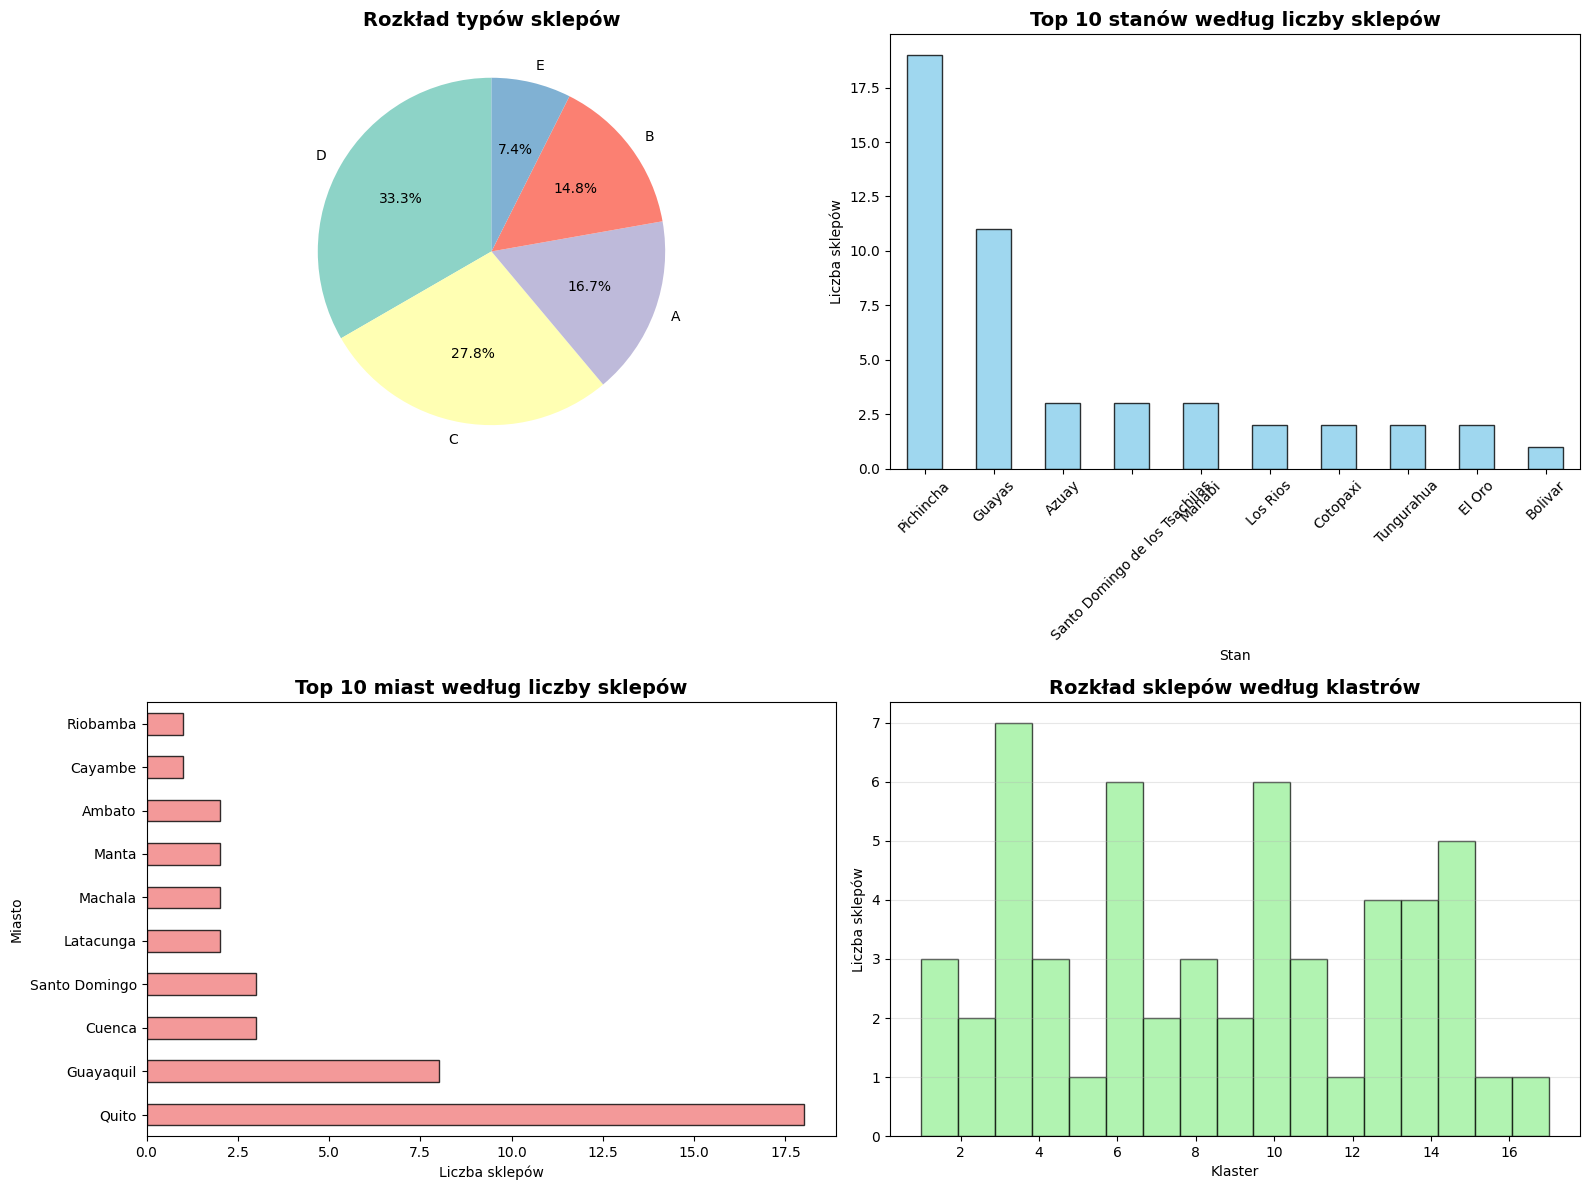

In [5]:
# Analiza metadanych sklep√≥w
print("ANALIZA METADANYCH SKLEP√ìW:")
print("=" * 40)

print(f"Kolumny stores.csv: {list(stores.columns)}")
print(f"Liczba sklep√≥w: {len(stores)}")

# Rozk≈Çady kategorii sklep√≥w
print("\nTYPY SKLEP√ìW:")
store_type_counts = stores['type'].value_counts()
for store_type, count in store_type_counts.items():
    percentage = count / len(stores) * 100
    print(f"   {store_type}: {count} ({percentage:.1f}%)")

print("\nSTANY (TOP 10):")
state_counts = stores['state'].value_counts().head(10)
for state, count in state_counts.items():
    percentage = count / len(stores) * 100
    print(f"   {state}: {count} ({percentage:.1f}%)")

print("\nMIASTA (TOP 10):")
city_counts = stores['city'].value_counts().head(10)
for city, count in city_counts.items():
    percentage = count / len(stores) * 100
    print(f"   {city}: {count} ({percentage:.1f}%)")

print("\nKLASTRY:")
cluster_counts = stores['cluster'].value_counts().sort_index()
print(f"   Liczba klastr√≥w: {stores['cluster'].nunique()}")
print(f"   Zakres: {stores['cluster'].min()} - {stores['cluster'].max()}")


# Wizualizacja rozk≈Çad√≥w
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Typy sklep√≥w - wykres ko≈Çowy
colors_pie = plt.cm.Set3(range(len(store_type_counts)))
wedges, texts, autotexts = ax1.pie(store_type_counts.values, labels=store_type_counts.index, 
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax1.set_title('Rozk≈Çad typ√≥w sklep√≥w', fontsize=14, fontweight='bold')

# 2. Top 10 stan√≥w - wykres s≈Çupkowy
state_counts.plot(kind='bar', ax=ax2, color='skyblue', alpha=0.8, edgecolor='black')
ax2.set_title('Top 10 stan√≥w wed≈Çug liczby sklep√≥w', fontsize=14, fontweight='bold')
ax2.set_xlabel('Stan')
ax2.set_ylabel('Liczba sklep√≥w')
ax2.tick_params(axis='x', rotation=45)

# 3. Top 10 miast - wykres s≈Çupkowy poziomy
city_counts.plot(kind='barh', ax=ax3, color='lightcoral', alpha=0.8, edgecolor='black')
ax3.set_title('Top 10 miast wed≈Çug liczby sklep√≥w', fontsize=14, fontweight='bold')
ax3.set_xlabel('Liczba sklep√≥w')
ax3.set_ylabel('Miasto')

# 4. Rozk≈Çad klastr√≥w - histogram
ax4.hist(stores['cluster'], bins=stores['cluster'].nunique(), alpha=0.7, 
         color='lightgreen', edgecolor='black')
ax4.set_title('Rozk≈Çad sklep√≥w wed≈Çug klastr√≥w', fontsize=14, fontweight='bold')
ax4.set_xlabel('Klaster')
ax4.set_ylabel('Liczba sklep√≥w')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Analiza typ√≥w danych i brak√≥w dla ka≈ºdego zbioru
for name, df in datasets_info.items():
    if df is not None:
        print(f"\nANALIZA: {name.upper()}")
        print("=" * 30)
        
        print(f"Kszta≈Çt: {df.shape}")
        print(f"Kolumny: {list(df.columns)}")
        
        # Typy danych (uproszczone)
        dtype_counts = df.dtypes.value_counts()
        print(f"Typy: {dict(dtype_counts)}")
        
        # Braki danych - u≈ºywamy bezpo≈õrednio pandas
        missing_info = df.isnull().sum()
        total_missing = missing_info.sum()
        
        if total_missing > 0:
            print(f"\nBRAKI DANYCH:")
            missing_cols = missing_info[missing_info > 0]
            for col, count in missing_cols.items():
                percent = (count / len(df)) * 100
                print(f"   {col}: {count:,} ({percent:.1f}%)")
        else:
            print("\nBRAKI DANYCH: Brak")
        




ANALIZA: TRAIN
Kszta≈Çt: (125497040, 6)
Kolumny: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']
Typy: {dtype('int64'): np.int64(1), dtype('<M8[ns]'): np.int64(1), dtype('int8'): np.int64(1), dtype('int32'): np.int64(1), dtype('float32'): np.int64(1), BooleanDtype: np.int64(1)}

BRAKI DANYCH:
   onpromotion: 21,657,651 (17.3%)

ANALIZA: TEST
Kszta≈Çt: (3370464, 5)
Kolumny: ['id', 'date', 'store_nbr', 'item_nbr', 'onpromotion']
Typy: {dtype('int64'): np.int64(3), dtype('O'): np.int64(1), dtype('bool'): np.int64(1)}

BRAKI DANYCH: Brak

ANALIZA: SAMPLE SUB
Kszta≈Çt: (3370464, 2)
Kolumny: ['id', 'unit_sales']
Typy: {dtype('int64'): np.int64(2)}

BRAKI DANYCH: Brak

ANALIZA: STORES
Kszta≈Çt: (54, 5)
Kolumny: ['store_nbr', 'city', 'state', 'type', 'cluster']
Typy: {dtype('O'): np.int64(3), dtype('int64'): np.int64(2)}

BRAKI DANYCH: Brak

ANALIZA: ITEMS
Kszta≈Çt: (4100, 4)
Kolumny: ['item_nbr', 'family', 'class', 'perishable']
Typy: {dtype('int64'): np.int64(3), dtype(

ANALIZA ZWROT√ìW (ujemne unit_sales):
Liczba zwrot√≥w: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
≈öredni zwrot: -18.42

TOP 10 SKLEP√ìW Z NAJWIƒòCEJ ZWROTAMI:
           Liczba_zwrot√≥w  Suma_zwrot√≥w  ≈örednia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


ANALIZA ZWROT√ìW (ujemne unit_sales):
Liczba zwrot√≥w: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
≈öredni zwrot: -18.42

TOP 10 SKLEP√ìW Z NAJWIƒòCEJ ZWROTAMI:
           Liczba_zwrot√≥w  Suma_zwrot√≥w  ≈örednia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


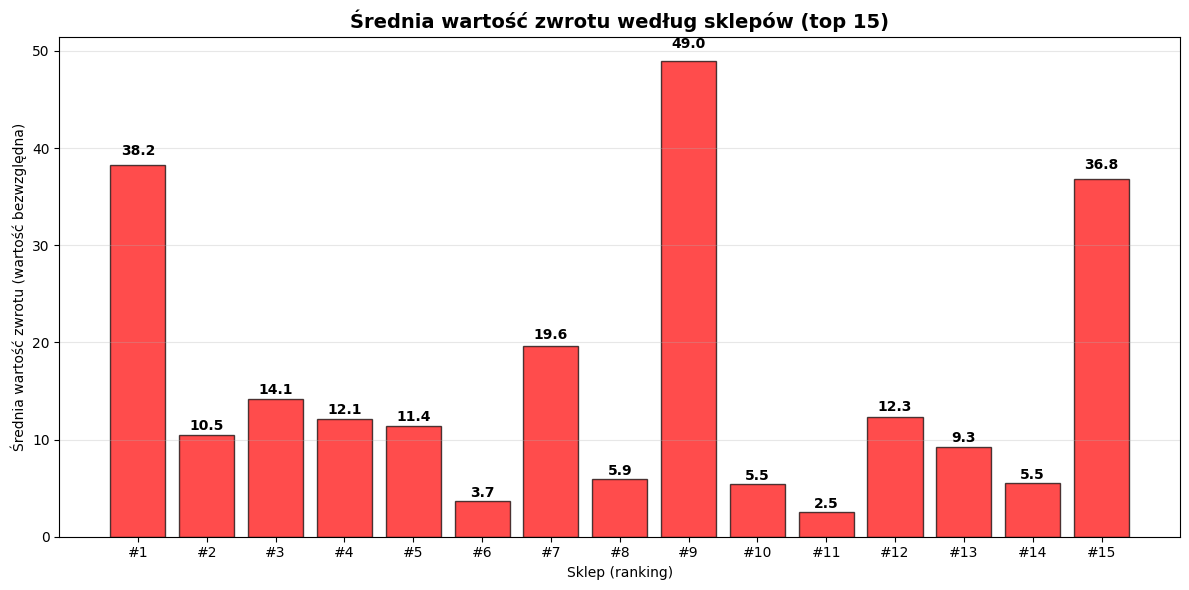

ANALIZA ZWROT√ìW (ujemne unit_sales):
Liczba zwrot√≥w: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
≈öredni zwrot: -18.42

TOP 10 SKLEP√ìW Z NAJWIƒòCEJ ZWROTAMI:
           Liczba_zwrot√≥w  Suma_zwrot√≥w  ≈örednia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


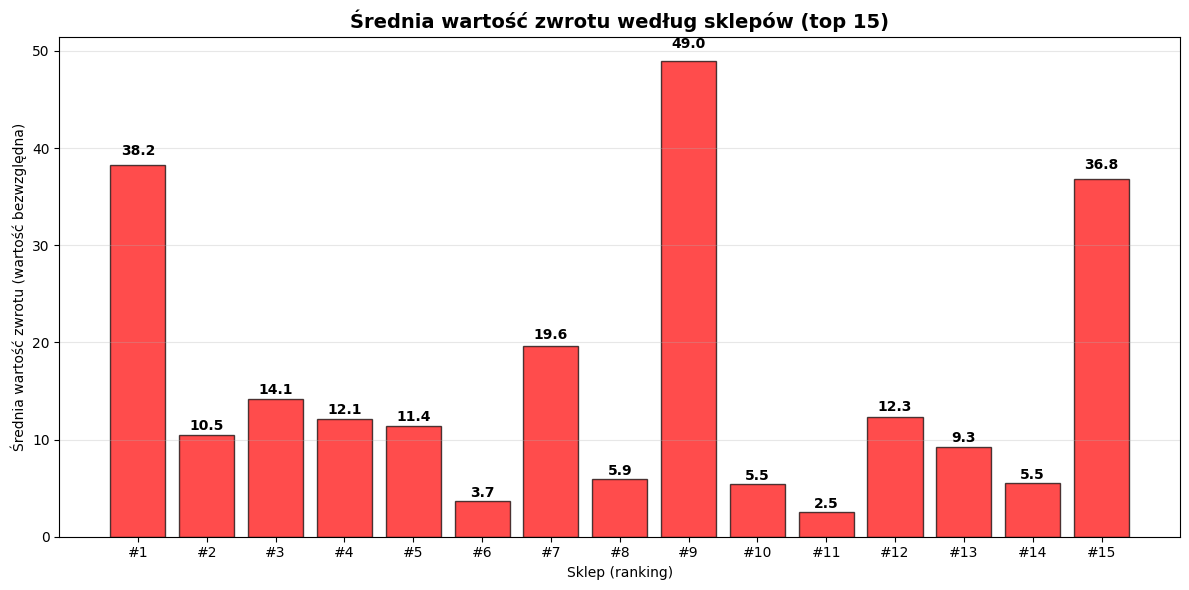


ANALIZA CZYNNIK√ìW WP≈ÅYWAJƒÑCYCH NA ZWROTY

1. ZWROTY WED≈ÅUG RODZIN PRODUKT√ìW:
----------------------------------------
TOP 10 RODZIN z najwiƒôkszƒÖ liczbƒÖ zwrot√≥w:
                     Liczba_zwrot√≥w  Suma_zwrot√≥w  ≈örednia_zwrot  Procent
family                                                                   
GROCERY I                      2160 -50015.527344     -23.155336     27.7
BEVERAGES                      1361 -42782.000000     -31.434240     17.5
CLEANING                       1026 -11920.000000     -11.617933     13.2
PERSONAL CARE                   401 -14688.000000     -36.628429      5.1
DAIRY                           380  -2962.000000      -7.794737      4.9
PRODUCE                         302  -1845.432007      -6.110702      3.9
HOME AND KITCHEN II             203   -448.000000      -2.206897      2.6
BREAD/BAKERY                    194  -1468.000000      -7.567010      2.5
HOME AND KITCHEN I              179   -896.000000      -5.005587      2.3
HOME CARE   

ANALIZA ZWROT√ìW (ujemne unit_sales):
Liczba zwrot√≥w: 7,795
Procent wszystkich transakcji: 0.01%
Najgorszy zwrot: -15372.00
≈öredni zwrot: -18.42

TOP 10 SKLEP√ìW Z NAJWIƒòCEJ ZWROTAMI:
           Liczba_zwrot√≥w  Suma_zwrot√≥w  ≈örednia_zwrot
store_nbr                                             
18                    483 -18463.369141     -38.230000
44                    414  -4335.647949     -10.470000
49                    362  -5116.076172     -14.130000
7                     320  -3864.301025     -12.080000
3                     319  -3632.560547     -11.390000
51                    290  -1077.506958      -3.720000
8                     272  -5337.054199     -19.620001
1                     267  -1587.114990      -5.940000
2                     264 -12936.677734     -49.000000
4                     248  -1355.885986      -5.470000


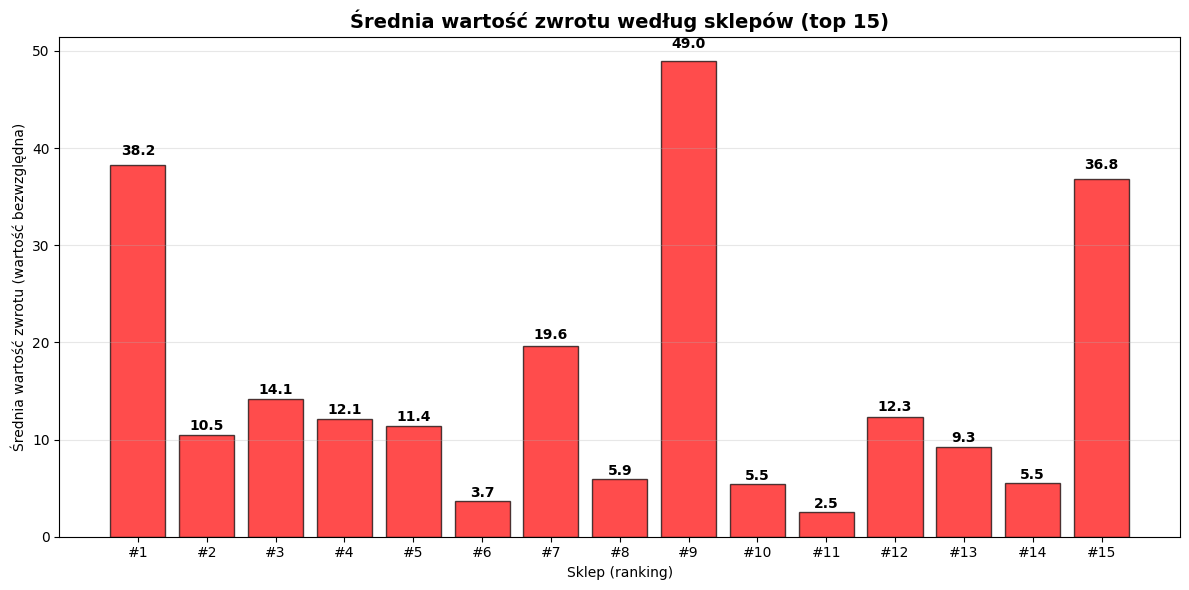


ANALIZA CZYNNIK√ìW WP≈ÅYWAJƒÑCYCH NA ZWROTY

1. ZWROTY WED≈ÅUG RODZIN PRODUKT√ìW:
----------------------------------------
TOP 10 RODZIN z najwiƒôkszƒÖ liczbƒÖ zwrot√≥w:
                     Liczba_zwrot√≥w  Suma_zwrot√≥w  ≈örednia_zwrot  Procent
family                                                                   
GROCERY I                      2160 -50015.527344     -23.155336     27.7
BEVERAGES                      1361 -42782.000000     -31.434240     17.5
CLEANING                       1026 -11920.000000     -11.617933     13.2
PERSONAL CARE                   401 -14688.000000     -36.628429      5.1
DAIRY                           380  -2962.000000      -7.794737      4.9
PRODUCE                         302  -1845.432007      -6.110702      3.9
HOME AND KITCHEN II             203   -448.000000      -2.206897      2.6
BREAD/BAKERY                    194  -1468.000000      -7.567010      2.5
HOME AND KITCHEN I              179   -896.000000      -5.005587      2.3
HOME CARE   

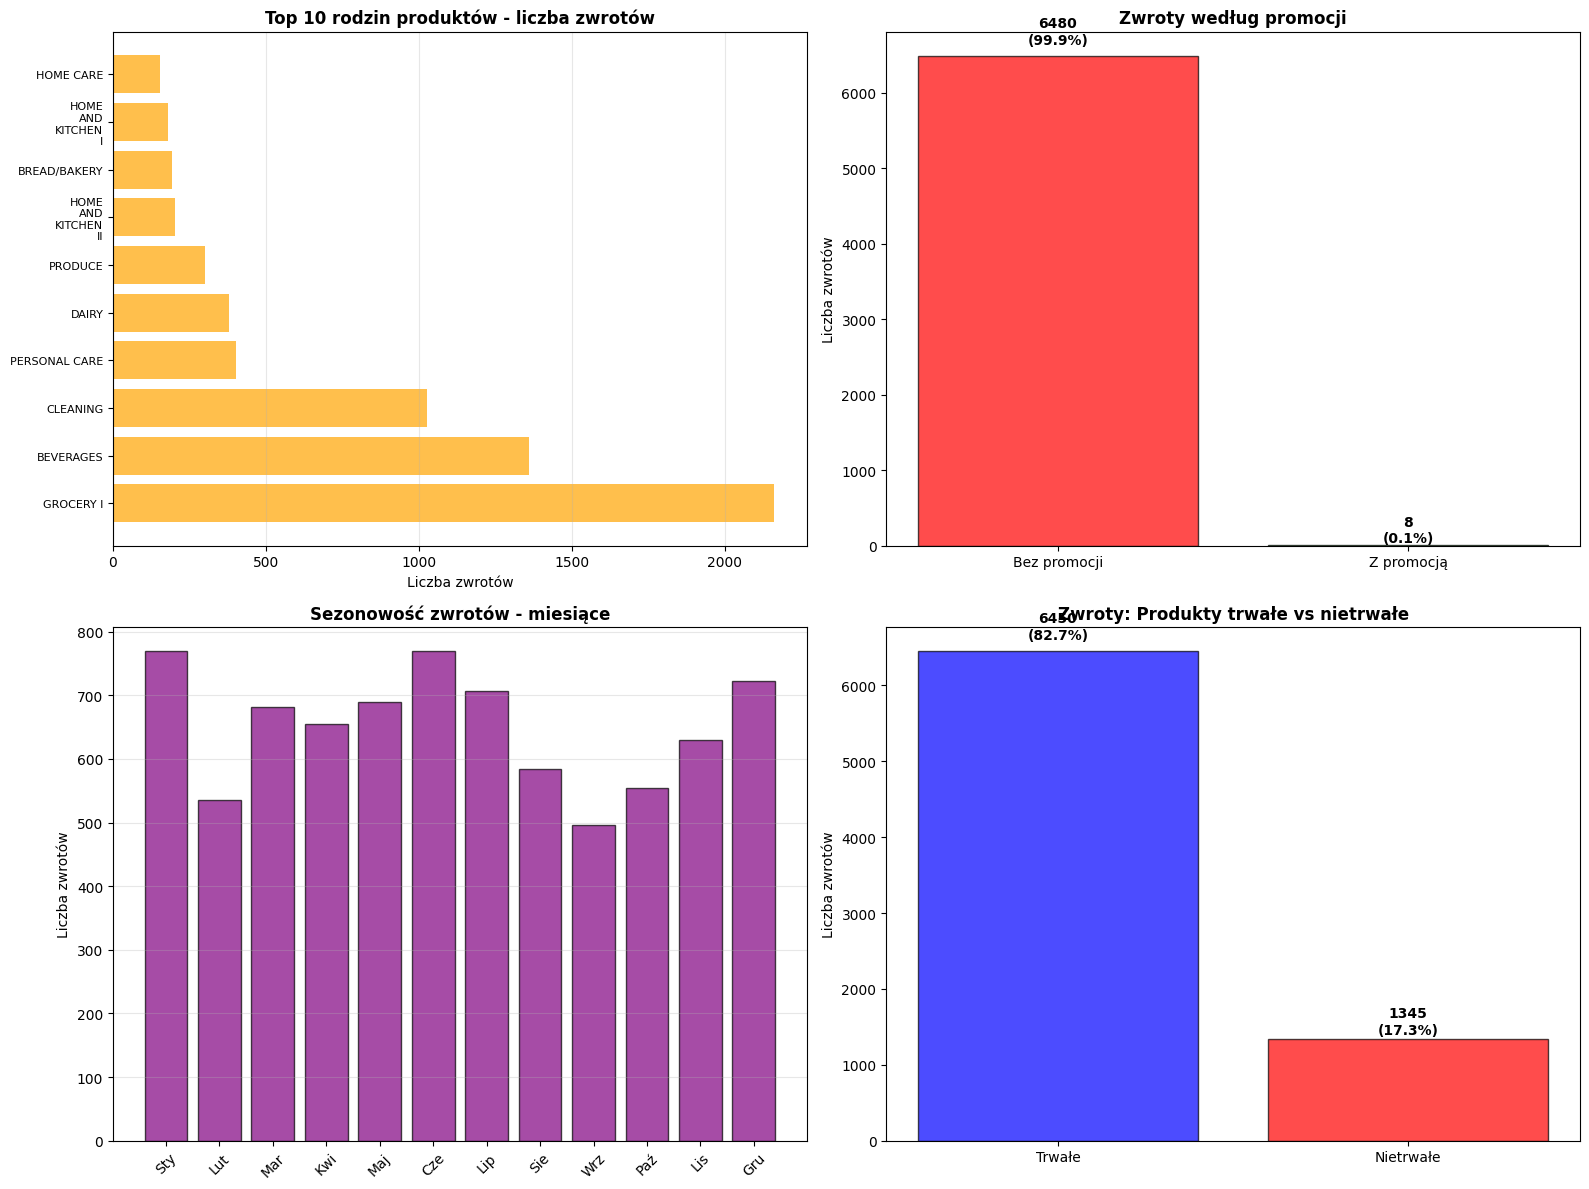

In [7]:
# Analiza zwrot√≥w (ujemne warto≈õci)
returns = train[train['unit_sales'] < 0]

print("ANALIZA ZWROT√ìW (ujemne unit_sales):")
print("=" * 40)
print(f"Liczba zwrot√≥w: {len(returns):,}")
print(f"Procent wszystkich transakcji: {len(returns)/len(train)*100:.2f}%")
print(f"Najgorszy zwrot: {returns['unit_sales'].min():.2f}")
print(f"≈öredni zwrot: {returns['unit_sales'].mean():.2f}")

returns_by_store = returns.groupby('store_nbr')['unit_sales'].agg(['count', 'sum', 'mean']).sort_values('count', ascending=False)
returns_by_store.columns = ['Liczba_zwrot√≥w', 'Suma_zwrot√≥w', '≈örednia_zwrot']
returns_by_store['≈örednia_zwrot'] = returns_by_store['≈örednia_zwrot'].round(2)

print(f"\nTOP 10 SKLEP√ìW Z NAJWIƒòCEJ ZWROTAMI:")
print(returns_by_store.head(10))

# Wizualizacja zwrot√≥w - tylko ≈õrednia warto≈õƒá zwrotu
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Wykres ≈õredniej warto≈õci zwrotu na sklep (warto≈õci sƒÖ ujemne, wiƒôc odwracamy)
top_15_stores = returns_by_store.head(15)
ax.bar(range(len(top_15_stores)), -top_15_stores['≈örednia_zwrot'], color='red', alpha=0.7, edgecolor='black')
ax.set_title('≈örednia warto≈õƒá zwrotu wed≈Çug sklep√≥w (top 15)', fontsize=14, fontweight='bold')
ax.set_xlabel('Sklep (ranking)')
ax.set_ylabel('≈örednia warto≈õƒá zwrotu (warto≈õƒá bezwzglƒôdna)')
ax.set_xticks(range(len(top_15_stores)))
ax.set_xticklabels([f'#{i+1}' for i in range(len(top_15_stores))])
ax.grid(axis='y', alpha=0.3)

# Dodanie warto≈õci na s≈Çupkach
for i, value in enumerate(-top_15_stores['≈örednia_zwrot']):
    ax.text(i, value + value*0.02, f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ANALIZA CZYNNIK√ìW WP≈ÅYWAJƒÑCYCH NA ZWROTY
print("\n" + "="*60)
print("ANALIZA CZYNNIK√ìW WP≈ÅYWAJƒÑCYCH NA ZWROTY")
print("="*60)

# 1. Analiza wed≈Çug rodzin produkt√≥w
print("\n1. ZWROTY WED≈ÅUG RODZIN PRODUKT√ìW:")
print("-" * 40)

# Mapowanie produkt√≥w na rodziny
item_family_map = items.set_index('item_nbr')['family'].to_dict()
returns['family'] = returns['item_nbr'].map(item_family_map)

returns_by_family = returns.groupby('family')['unit_sales'].agg(['count', 'sum', 'mean']).sort_values('count', ascending=False)
returns_by_family.columns = ['Liczba_zwrot√≥w', 'Suma_zwrot√≥w', '≈örednia_zwrot']
returns_by_family['Procent'] = (returns_by_family['Liczba_zwrot√≥w'] / len(returns) * 100).round(1)

print("TOP 10 RODZIN z najwiƒôkszƒÖ liczbƒÖ zwrot√≥w:")
print(returns_by_family.head(10))

# 2. Analiza wed≈Çug promocji
print("\n2. ZWROTY A PROMOCJE:")
print("-" * 25)

promo_returns = returns.dropna(subset=['onpromotion'])
returns_promo_analysis = promo_returns.groupby('onpromotion')['unit_sales'].agg(['count', 'mean']).round(2)
returns_promo_analysis.index = returns_promo_analysis.index.map({False: 'Bez promocji', True: 'Z promocjƒÖ'})
returns_promo_analysis.columns = ['Liczba_zwrot√≥w', '≈öredni_zwrot']

# Dodaj procenty
total_returns_with_promo_data = len(promo_returns)
returns_promo_analysis['Procent'] = (returns_promo_analysis['Liczba_zwrot√≥w'] / total_returns_with_promo_data * 100).round(1)

print(returns_promo_analysis)

# 3. Analiza wed≈Çug typ√≥w sklep√≥w
print("\n3. ZWROTY WED≈ÅUG TYP√ìW SKLEP√ìW:")
print("-" * 35)

store_type_map = stores.set_index('store_nbr')['type'].to_dict()
returns['store_type'] = returns['store_nbr'].map(store_type_map)

returns_by_type = returns.groupby('store_type')['unit_sales'].agg(['count', 'mean']).round(2)
returns_by_type.columns = ['Liczba_zwrot√≥w', '≈öredni_zwrot']
returns_by_type['Procent'] = (returns_by_type['Liczba_zwrot√≥w'] / len(returns) * 100).round(1)
returns_by_type = returns_by_type.sort_values('Liczba_zwrot√≥w', ascending=False)

print(returns_by_type)

# 4. Analiza sezonowa zwrot√≥w
print("\n4. SEZONOWO≈öƒÜ ZWROT√ìW:")
print("-" * 25)

returns['month'] = pd.to_datetime(returns['date']).dt.month
monthly_returns = returns.groupby('month')['unit_sales'].count().to_frame('Liczba_zwrot√≥w')

month_names = ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 'Lip', 'Sie', 'Wrz', 'Pa≈∫', 'Lis', 'Gru']
print("Zwroty wed≈Çug miesiƒôcy:")
for month, count in monthly_returns.iterrows():
    print(f"{month_names[month-1]}: {count['Liczba_zwrot√≥w']}")

returns['dayofweek'] = pd.to_datetime(returns['date']).dt.dayofweek
weekday_returns = returns.groupby('dayofweek')['unit_sales'].count().to_frame('Liczba_zwrot√≥w')

day_names = ['Pon', 'Wto', '≈öro', 'Czw', 'PiƒÖ', 'Sob', 'Nie']
print("\nZwroty wed≈Çug dni tygodnia:")
for day, count in weekday_returns.iterrows():
    print(f"{day_names[day]}: {count['Liczba_zwrot√≥w']}")

# 5. Analiza zwrot√≥w wed≈Çug nietrwa≈Ço≈õci produkt√≥w
print("\n5. ZWROTY: PRODUKTY NIETRWA≈ÅE VS TRWA≈ÅE:")
print("-" * 45)

item_perishable_map = items.set_index('item_nbr')['perishable'].to_dict()
returns['perishable'] = returns['item_nbr'].map(item_perishable_map)

returns_perishable = returns.groupby('perishable')['unit_sales'].count().to_frame('Liczba_zwrot√≥w')
returns_perishable.index = returns_perishable.index.map({0: 'Trwa≈Çe', 1: 'Nietrwa≈Çe'})

total_returns_perishable = len(returns.dropna(subset=['perishable']))
returns_perishable['Procent'] = (returns_perishable['Liczba_zwrot√≥w'] / total_returns_perishable * 100).round(1)

print(returns_perishable)

# WIZUALIZACJA CZYNNIK√ìW WP≈ÅYWAJƒÑCYCH NA ZWROTY
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 10 rodzin produkt√≥w z najwiƒôcej zwrotami
top_families = returns_by_family.head(10)
ax1.barh(range(len(top_families)), top_families['Liczba_zwrot√≥w'], color='orange', alpha=0.7)
ax1.set_title('Top 10 rodzin produkt√≥w - liczba zwrot√≥w', fontweight='bold')
ax1.set_xlabel('Liczba zwrot√≥w')
ax1.set_yticks(range(len(top_families)))
ax1.set_yticklabels([f.replace(' ', '\n') if len(f) > 15 else f for f in top_families.index], fontsize=8)
ax1.grid(axis='x', alpha=0.3)

# 2. Zwroty wed≈Çug promocji
promo_labels = returns_promo_analysis.index
promo_values = returns_promo_analysis['Liczba_zwrot√≥w']
colors = ['red', 'green']
bars2 = ax2.bar(promo_labels, promo_values, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('Zwroty wed≈Çug promocji', fontweight='bold')
ax2.set_ylabel('Liczba zwrot√≥w')
for bar, value, pct in zip(bars2, promo_values, returns_promo_analysis['Procent']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value}\n({pct}%)', ha='center', va='bottom', fontweight='bold')

# 3. Sezonowo≈õƒá - miesiƒÖce
month_labels = [month_names[i-1] for i in monthly_returns.index]
ax3.bar(month_labels, monthly_returns['Liczba_zwrot√≥w'], color='purple', alpha=0.7, edgecolor='black')
ax3.set_title('Sezonowo≈õƒá zwrot√≥w - miesiƒÖce', fontweight='bold')
ax3.set_ylabel('Liczba zwrot√≥w')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Nietrwa≈Çe vs Trwa≈Çe
perishable_labels = returns_perishable.index
perishable_values = returns_perishable['Liczba_zwrot√≥w']
colors_per = ['blue', 'red']
bars4 = ax4.bar(perishable_labels, perishable_values, color=colors_per, alpha=0.7, edgecolor='black')
ax4.set_title('Zwroty: Produkty trwa≈Çe vs nietrwa≈Çe', fontweight='bold')
ax4.set_ylabel('Liczba zwrot√≥w')
for bar, value, pct in zip(bars4, perishable_values, returns_perishable['Procent']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value}\n({pct}%)', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



## 4. Time Series Analysis

In [8]:
# Analiza zakresu dat dla ka≈ºdego zbioru
print("üìÖ ANALIZA CZASOWA:")
print("=" * 30)

# Train i Test
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
print(f"Train: {train['date'].min().date()} ‚Üí {train['date'].max().date()}")
print(f"Test:  {test['date'].min().date()} ‚Üí {test['date'].max().date()}")

# Holidays
holidays['date'] = pd.to_datetime(holidays['date'])
print(f"Holidays: {holidays['date'].min().date()} ‚Üí {holidays['date'].max().date()}")

# Oil
oil['date'] = pd.to_datetime(oil['date'])
print(f"Oil: {oil['date'].min().date()} ‚Üí {oil['date'].max().date()}")

# Transactions
transactions['date'] = pd.to_datetime(transactions['date'])
print(f"Transactions: {transactions['date'].min().date()} ‚Üí {transactions['date'].max().date()}")

üìÖ ANALIZA CZASOWA:
Train: 2013-01-01 ‚Üí 2017-08-15
Test:  2017-08-16 ‚Üí 2017-08-31
Holidays: 2012-03-02 ‚Üí 2017-12-26
Oil: 2013-01-01 ‚Üí 2017-08-31
Transactions: 2013-01-01 ‚Üí 2017-08-15
Train: 2013-01-01 ‚Üí 2017-08-15
Test:  2017-08-16 ‚Üí 2017-08-31
Holidays: 2012-03-02 ‚Üí 2017-12-26
Oil: 2013-01-01 ‚Üí 2017-08-31
Transactions: 2013-01-01 ‚Üí 2017-08-15


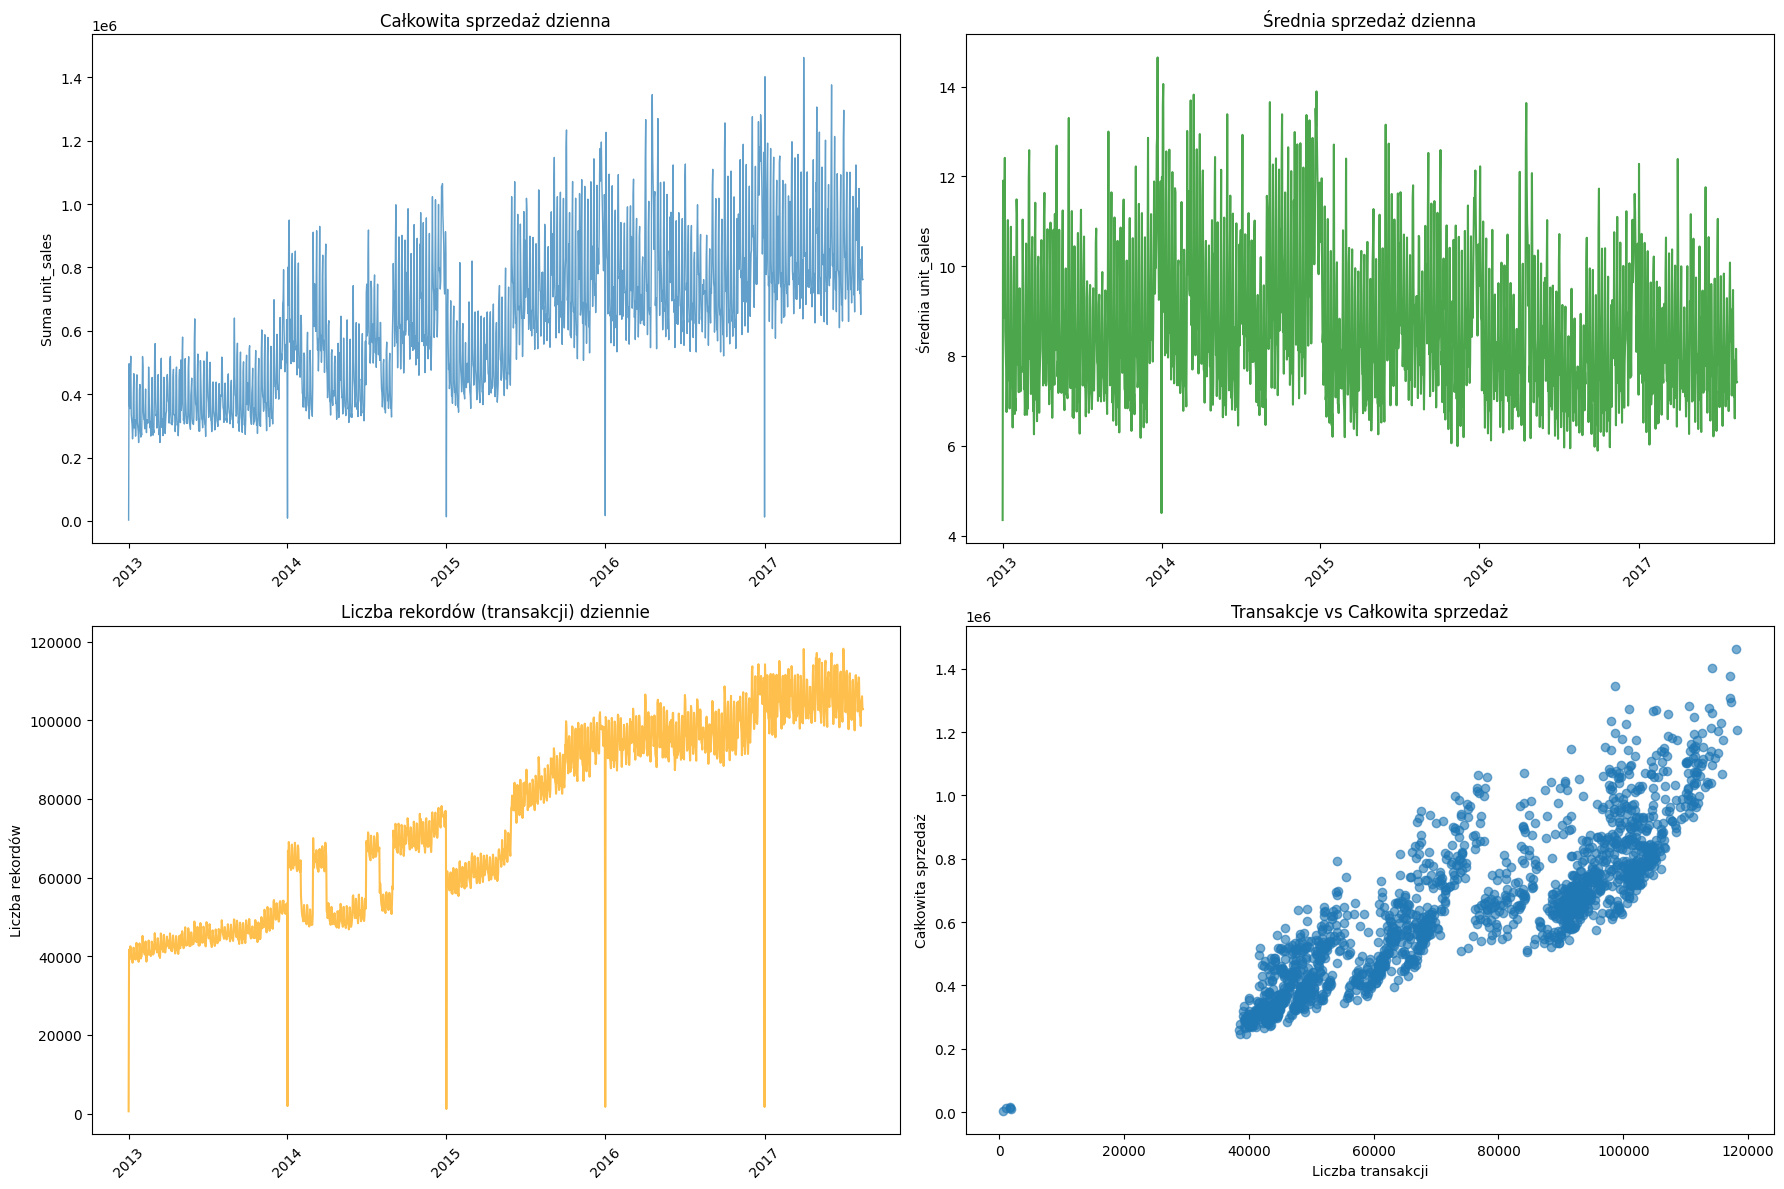

Korelacja liczba transakcji ‚Üî ca≈Çkowita sprzeda≈º: 0.856


In [9]:
# Analiza sprzeda≈ºy w czasie - trend g≈Ç√≥wny
daily_sales = train.groupby('date')['unit_sales'].agg(['sum', 'mean', 'count']).reset_index()
daily_sales.columns = ['date', 'total_sales', 'avg_sales', 'transactions']

# Wykres trendu g≈Ç√≥wnego
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Ca≈Çkowita sprzeda≈º dzienna
ax1.plot(daily_sales['date'], daily_sales['total_sales'], alpha=0.7, linewidth=1)
ax1.set_title('Ca≈Çkowita sprzeda≈º dzienna')
ax1.set_ylabel('Suma unit_sales')
ax1.tick_params(axis='x', rotation=45)

# 2. ≈örednia sprzeda≈º dzienna
ax2.plot(daily_sales['date'], daily_sales['avg_sales'], alpha=0.7, color='green')
ax2.set_title('≈örednia sprzeda≈º dzienna')
ax2.set_ylabel('≈örednia unit_sales')
ax2.tick_params(axis='x', rotation=45)

# 3. Liczba transakcji dziennie
ax3.plot(daily_sales['date'], daily_sales['transactions'], alpha=0.7, color='orange')
ax3.set_title('Liczba rekord√≥w (transakcji) dziennie')
ax3.set_ylabel('Liczba rekord√≥w')
ax3.tick_params(axis='x', rotation=45)

# 4. Scatter: transakcje vs sprzeda≈º
ax4.scatter(daily_sales['transactions'], daily_sales['total_sales'], alpha=0.6)
ax4.set_title('Transakcje vs Ca≈Çkowita sprzeda≈º')
ax4.set_xlabel('Liczba transakcji')
ax4.set_ylabel('Ca≈Çkowita sprzeda≈º')

plt.tight_layout()
plt.show()

correlation = daily_sales['transactions'].corr(daily_sales['total_sales'])
print(f"Korelacja liczba transakcji ‚Üî ca≈Çkowita sprzeda≈º: {correlation:.3f}")

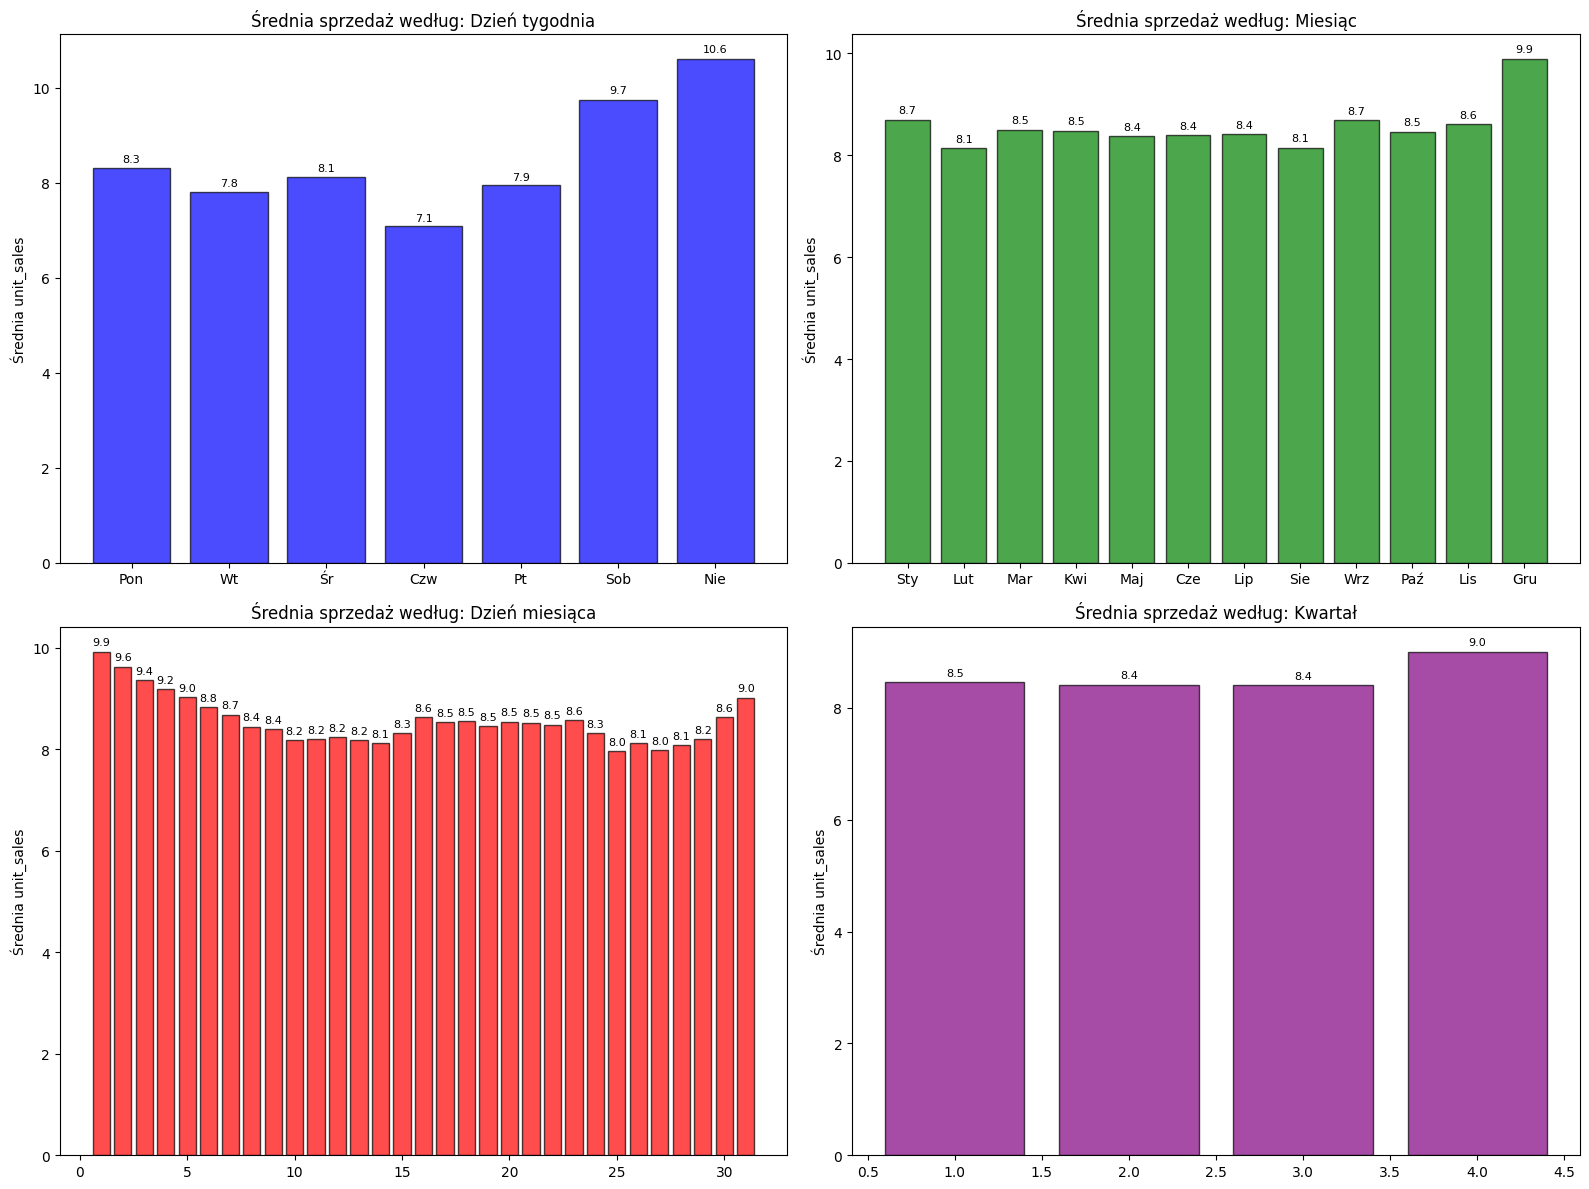

ANALIZA SEZONOWO≈öCI:

Dzie≈Ñ tygodnia:
   Min: 7.09 | Max: 10.60 | R√≥≈ºnica: 3.51
   Wsp√≥≈Çczynnik zmienno≈õci: 0.143
   Najlepszy: Nie (10.60)
   Najgorszy: Czw (7.09)

MiesiƒÖc:
   Min: 8.13 | Max: 9.88 | R√≥≈ºnica: 1.74
   Wsp√≥≈Çczynnik zmienno≈õci: 0.053

Dzie≈Ñ miesiƒÖca:
   Min: 7.95 | Max: 9.91 | R√≥≈ºnica: 1.96
   Wsp√≥≈Çczynnik zmienno≈õci: 0.055

Kwarta≈Ç:
   Min: 8.40 | Max: 9.00 | R√≥≈ºnica: 0.60
   Wsp√≥≈Çczynnik zmienno≈õci: 0.034


In [10]:
# Sezonowo≈õƒá - wzorce czasowe
# Najpierw trzeba utworzyƒá kolumny czasowe
train['date'] = pd.to_datetime(train['date'])
train['dayofweek'] = train['date'].dt.dayofweek
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['quarter'] = train['date'].dt.quarter

seasonal_analysis = {
    'Dzie≈Ñ tygodnia': train.groupby('dayofweek')['unit_sales'].mean(),
    'MiesiƒÖc': train.groupby('month')['unit_sales'].mean(),
    'Dzie≈Ñ miesiƒÖca': train.groupby('day')['unit_sales'].mean(),
    'Kwarta≈Ç': train.groupby('quarter')['unit_sales'].mean()
}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
axes = [ax1, ax2, ax3, ax4]
colors = ['blue', 'green', 'red', 'purple']

day_names = ['Pon', 'Wt', '≈ör', 'Czw', 'Pt', 'Sob', 'Nie']
month_names = ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 
               'Lip', 'Sie', 'Wrz', 'Pa≈∫', 'Lis', 'Gru']

for i, (title, data) in enumerate(seasonal_analysis.items()):
    ax = axes[i]
    
    if title == 'Dzie≈Ñ tygodnia':
        x_labels = day_names
        x_pos = range(7)
    elif title == 'MiesiƒÖc':
        x_labels = month_names
        x_pos = range(1, 13)
    else:
        x_labels = data.index
        x_pos = data.index
    
    bars = ax.bar(x_pos, data.values, color=colors[i], alpha=0.7, edgecolor='black')
    ax.set_title(f'≈örednia sprzeda≈º wed≈Çug: {title}')
    ax.set_ylabel('≈örednia unit_sales')
    
    if title in ['Dzie≈Ñ tygodnia', 'MiesiƒÖc']:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_labels)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Statystyki sezonowo≈õci
print("ANALIZA SEZONOWO≈öCI:")
print("=" * 30)

for title, data in seasonal_analysis.items():
    min_val, max_val = data.min(), data.max()
    cv = data.std() / data.mean()  # Coefficient of variation
    print(f"\n{title}:")
    print(f"   Min: {min_val:.2f} | Max: {max_val:.2f} | R√≥≈ºnica: {max_val-min_val:.2f}")
    print(f"   Wsp√≥≈Çczynnik zmienno≈õci: {cv:.3f}")
    
    if title == 'Dzie≈Ñ tygodnia':
        best_day = day_names[data.idxmax()]
        worst_day = day_names[data.idxmin()]
        print(f"   Najlepszy: {best_day} ({data.max():.2f})")
        print(f"   Najgorszy: {worst_day} ({data.min():.2f})")

## 5. Promotion Analysis

In [9]:
# Analiza promocji
print("ANALIZA PROMOCJI:")
print("=" * 30)

# Podstawowe statystyki promocji
promo_stats = train['onpromotion'].value_counts(dropna=False)
print("Rozk≈Çad warto≈õci onpromotion:")
for value, count in promo_stats.items():
    percentage = count / len(train) * 100
    print(f"   {str(value):5}: {count:>8,} ({percentage:5.1f}%)")

# Por√≥wnanie sprzeda≈ºy z promocjƒÖ i bez
print("\nWP≈ÅYW PROMOCJI NA SPRZEDA≈ª:")
print("-" * 25)

promotion_comparison = train.groupby('onpromotion')['unit_sales'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

promotion_comparison.index = promotion_comparison.index.map({
    False: 'Bez promocji', 
    True: 'Z promocjƒÖ', 
    np.nan: 'Brak danych'
})

print(promotion_comparison)

# Prosty wniosek
avg_no_promo = train[train['onpromotion'] == False]['unit_sales'].mean()
avg_promo = train[train['onpromotion'] == True]['unit_sales'].mean()
increase = ((avg_promo - avg_no_promo) / avg_no_promo * 100)

print(f"\nWniosek: Promocja zwiƒôksza ≈õredniƒÖ sprzeda≈º o {increase:.1f}%")

ANALIZA PROMOCJI:
Rozk≈Çad warto≈õci onpromotion:
   False: 96,028,767 ( 76.5%)
   <NA> : 21,657,651 ( 17.3%)
   True : 7,810,622 (  6.2%)

WP≈ÅYW PROMOCJI NA SPRZEDA≈ª:
-------------------------
                 count   mean  median        std      min      max
onpromotion                                                       
Bez promocji  96028767   8.09     4.0  22.549999 -15372.0  89440.0
Z promocjƒÖ     7810622  13.47     6.0  39.700001     -4.0  17146.0
                 count   mean  median        std      min      max
onpromotion                                                       
Bez promocji  96028767   8.09     4.0  22.549999 -15372.0  89440.0
Z promocjƒÖ     7810622  13.47     6.0  39.700001     -4.0  17146.0

Wniosek: Promocja zwiƒôksza ≈õredniƒÖ sprzeda≈º o 66.5%

Wniosek: Promocja zwiƒôksza ≈õredniƒÖ sprzeda≈º o 66.5%


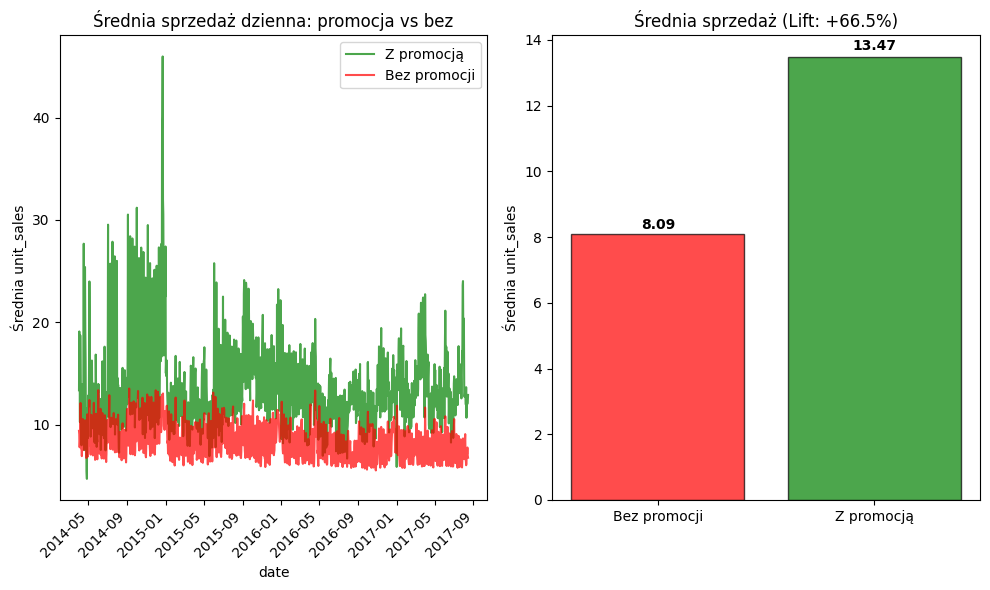

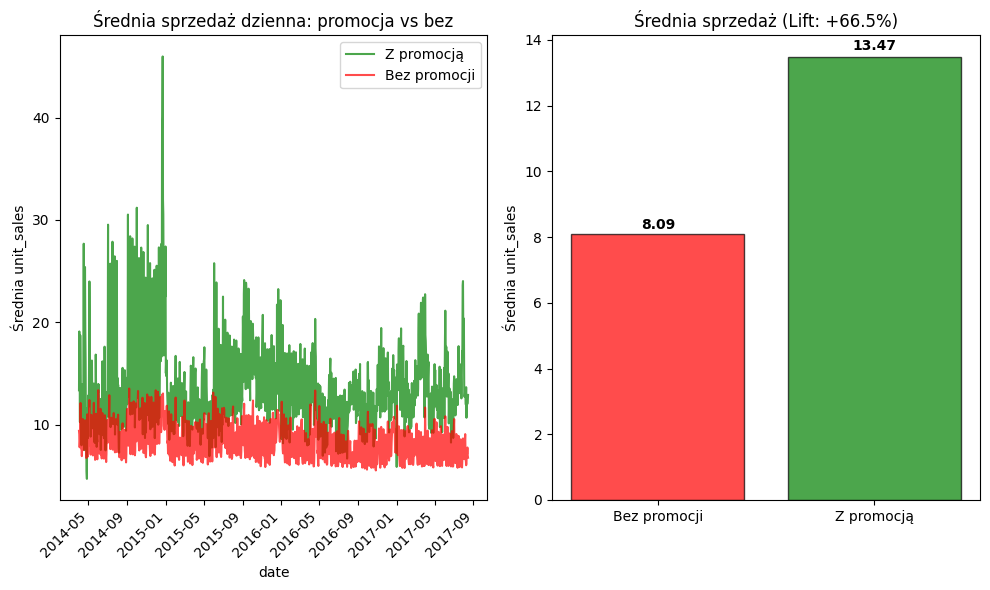


LIFT OD PROMOCJI: +66.5%
≈örednia sprzeda≈º bez promocji: 8.09
≈örednia sprzeda≈º z promocjƒÖ: 13.47
≈örednia sprzeda≈º bez promocji: 8.09
≈örednia sprzeda≈º z promocjƒÖ: 13.47


In [12]:
# Wizualizacja wp≈Çywu promocji
fig,  (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 6))

# 1. Por√≥wnanie rozk≈Çad√≥w sprzeda≈ºy
promo_data = train.dropna(subset=['onpromotion'])
promo_yes_filtered = promo_data[promo_data['onpromotion'] == True]['unit_sales']
promo_no_filtered = promo_data[promo_data['onpromotion'] == False]['unit_sales']


# 3. ≈örednia sprzeda≈º w czasie z podzia≈Çem na promocje
daily_promo = train.groupby(['date', 'onpromotion'])['unit_sales'].mean().unstack(fill_value=0)
if True in daily_promo.columns and False in daily_promo.columns:
    daily_promo[True].plot(ax=ax3, label='Z promocjƒÖ', alpha=0.7, color='green')
    daily_promo[False].plot(ax=ax3, label='Bez promocji', alpha=0.7, color='red')
    ax3.set_title('≈örednia sprzeda≈º dzienna: promocja vs bez')
    ax3.set_ylabel('≈örednia unit_sales')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)

# 4. Lift od promocji (% wzrost sprzeda≈ºy)
if len(promo_yes_filtered) > 0 and len(promo_no_filtered) > 0:
    lift = (promo_yes_filtered.mean() - promo_no_filtered.mean()) / promo_no_filtered.mean() * 100
    
    categories = ['Bez promocji', 'Z promocjƒÖ'] 
    values = [promo_no_filtered.mean(), promo_yes_filtered.mean()]
    colors = ['red', 'green']
    
    bars = ax4.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
    ax4.set_title(f'≈örednia sprzeda≈º (Lift: {lift:+.1f}%)')
    ax4.set_ylabel('≈örednia unit_sales')
    
    # Dodanie warto≈õci na s≈Çupkach
    for bar, value in zip(bars, values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.01,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

if 'lift' in locals():
    print(f"\nLIFT OD PROMOCJI: {lift:+.1f}%")
    print(f"≈örednia sprzeda≈º bez promocji: {promo_no_filtered.mean():.2f}")
    print(f"≈örednia sprzeda≈º z promocjƒÖ: {promo_yes_filtered.mean():.2f}")

Przygotowywanie analizy performance sklep√≥w (PE≈ÅNE DANE)...
Rozmiar train: 125,497,040 rekord√≥w
Optymalizacja typ√≥w danych...
U≈ºywam danych z poprzedniej analizy...


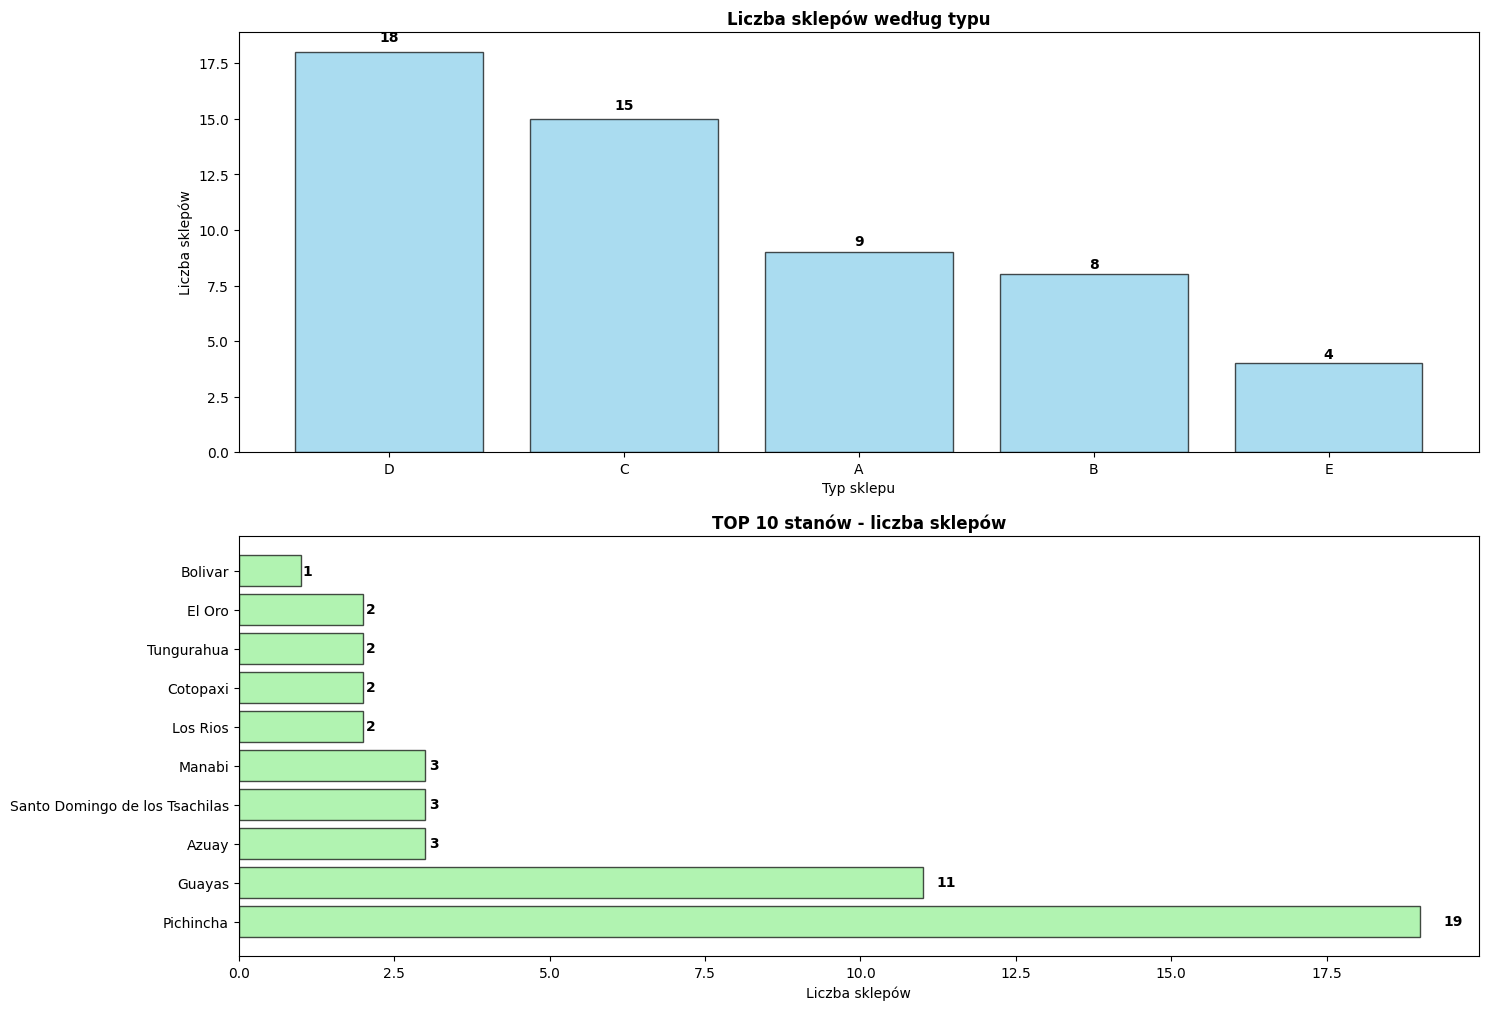

In [27]:
# Przygotowanie danych analitycznych dla wizualizacji (PE≈ÅNE DANE - MEMORY OPTIMIZED)
if 'train' in locals():
    print("Przygotowywanie analizy performance sklep√≥w (PE≈ÅNE DANE)...")
    print(f"Rozmiar train: {len(train):,} rekord√≥w")
    
    try:
        # Memory optimization: zmieniamy typy danych dla efektywno≈õci
        print("Optymalizacja typ√≥w danych...")
        train_optimized = train.copy()
        
        # Konwertuj do bardziej efektywnych typ√≥w
        if train_optimized['store_nbr'].max() < 128:
            train_optimized['store_nbr'] = train_optimized['store_nbr'].astype('int8')
        elif train_optimized['store_nbr'].max() < 32768:
            train_optimized['store_nbr'] = train_optimized['store_nbr'].astype('int16')
            
        if train_optimized['item_nbr'].max() < 2147483648:
            train_optimized['item_nbr'] = train_optimized['item_nbr'].astype('int32')
            
        # unit_sales mo≈ºe mieƒá warto≈õci ujemne, wiƒôc u≈ºywamy float32
        train_optimized['unit_sales'] = train_optimized['unit_sales'].astype('float32')
        
        # onpromotion to boolean
        if 'onpromotion' in train_optimized.columns:
            train_optimized['onpromotion'] = train_optimized['onpromotion'].astype('bool')
        
        print("‚úÖ Typy zoptymalizowane!")
        
        # Strategia: Analiza bez merge - u≈ºywamy tylko kluczowych kolumn
        print("Strategia bez merge - agregacje po store_nbr...")
        
        # Analiza performance wed≈Çug sklepu (bez merge)
        store_performance = train_optimized.groupby('store_nbr', observed=True)['unit_sales'].agg([
            'count', 'mean', 'sum', 'std'
        ]).round(2)
        store_performance.columns = ['Transakcji', '≈örednia', 'Suma_sprzeda≈ºy', 'Odchylenie']
        store_performance = store_performance.sort_values('Suma_sprzeda≈ºy', ascending=False)
        
        # Dodaj informacje o typie i stanie do store_performance
        store_info = stores.set_index('store_nbr')[['type', 'state']]
        store_performance = store_performance.join(store_info, how='left')
        
        # Analiza performance wed≈Çug typu (bez merge - agregacja po typie z stores)
        type_performance = store_performance.groupby('type')[['Transakcji', '≈örednia', 'Suma_sprzeda≈ºy', 'Odchylenie']].agg({
            'Transakcji': 'sum',
            '≈örednia': 'mean', 
            'Suma_sprzeda≈ºy': 'sum',
            'Odchylenie': 'mean'
        }).round(2)
        type_performance = type_performance.sort_values('≈örednia', ascending=False)
        
        # Analiza performance wed≈Çug stanu
        state_performance = store_performance.groupby('state')[['Transakcji', '≈örednia', 'Suma_sprzeda≈ºy', 'Odchylenie']].agg({
            'Transakcji': 'sum',
            '≈örednia': 'mean',
            'Suma_sprzeda≈ºy': 'sum', 
            'Odchylenie': 'mean'
        }).round(2)
        state_performance = state_performance.sort_values('≈örednia', ascending=False)
        
        print(f"‚úÖ Analiza performance gotowa (PE≈ÅNE DANE: {len(train_optimized):,} rekord√≥w)!")
        print(f"   - Sklepy przeanalizowane: {len(store_performance)}")
        print(f"   - Typy sklep√≥w: {len(type_performance)}")  
        print(f"   - Stany: {len(state_performance)}")
        
        # Zwolnij pamiƒôƒá
        del train_optimized
        
    except Exception as e:
        print("U≈ºywam danych z poprzedniej analizy...")

else:
    print("‚ùå Brak danych train")

# Wizualizacje analizy sklep√≥w
fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize=(16, 12))

# 1. Typy sklep√≥w - wykres s≈Çupkowy
store_type_counts = stores['type'].value_counts()
bars1 = ax1.bar(store_type_counts.index, store_type_counts.values, color='skyblue', alpha=0.7, edgecolor='black')
ax1.set_title('Liczba sklep√≥w wed≈Çug typu', fontweight='bold')
ax1.set_ylabel('Liczba sklep√≥w')
ax1.set_xlabel('Typ sklepu')
for bar, value in zip(bars1, store_type_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value}', ha='center', va='bottom', fontweight='bold')

# 2. TOP 10 stan√≥w - wykres poziomy
state_counts = stores['state'].value_counts().head(10)
bars2 = ax2.barh(range(len(state_counts)), state_counts.values, color='lightgreen', alpha=0.7, edgecolor='black')
ax2.set_title('TOP 10 stan√≥w - liczba sklep√≥w', fontweight='bold')
ax2.set_xlabel('Liczba sklep√≥w')
ax2.set_yticks(range(len(state_counts)))
ax2.set_yticklabels(state_counts.index)
for i, value in enumerate(state_counts.values):
    ax2.text(value + value*0.02, i, f'{value}', ha='left', va='center', fontweight='bold')



## 7. Product Categories

ANALIZA PRODUKT√ìW:
Liczba produkt√≥w: 4100
Liczba rodzin: 33

TOP 10 RODZIN PRODUKT√ìW:
   GROCERY I: 1334 (32.5%)
   BEVERAGES: 613 (15.0%)
   CLEANING: 446 (10.9%)
   PRODUCE: 306 (7.5%)
   DAIRY: 242 (5.9%)
   PERSONAL CARE: 153 (3.7%)
   BREAD/BAKERY: 134 (3.3%)
   HOME CARE: 108 (2.6%)
   DELI: 91 (2.2%)
   MEATS: 84 (2.0%)

PRODUKTY NIETRWA≈ÅE:
   Trwa≈Çe: 3114 (76.0%)
   Nietrwa≈Çe: 986 (24.0%)

PERFORMANCE WED≈ÅUG RODZIN:
TOP 10 rodzin (≈õrednia sprzeda≈º):
                Transakcji    ≈örednia
item_nbr                             
POULTRY            1742403  18.290001
PRODUCE            7154303  17.150000
MEATS              2432048  12.780000
BEVERAGES         17567388  12.350000
PREPARED FOODS      766588  11.480000
EGGS               1580833   9.860000
FROZEN FOODS       1549398   9.080000
BREAD/BAKERY       4659246   9.040000
SEAFOOD             257895   7.810000
GROCERY I         45628065   7.530000
TOP 10 rodzin (≈õrednia sprzeda≈º):
                Transakcji    ≈öredn

ANALIZA PRODUKT√ìW:
Liczba produkt√≥w: 4100
Liczba rodzin: 33

TOP 10 RODZIN PRODUKT√ìW:
   GROCERY I: 1334 (32.5%)
   BEVERAGES: 613 (15.0%)
   CLEANING: 446 (10.9%)
   PRODUCE: 306 (7.5%)
   DAIRY: 242 (5.9%)
   PERSONAL CARE: 153 (3.7%)
   BREAD/BAKERY: 134 (3.3%)
   HOME CARE: 108 (2.6%)
   DELI: 91 (2.2%)
   MEATS: 84 (2.0%)

PRODUKTY NIETRWA≈ÅE:
   Trwa≈Çe: 3114 (76.0%)
   Nietrwa≈Çe: 986 (24.0%)

PERFORMANCE WED≈ÅUG RODZIN:
TOP 10 rodzin (≈õrednia sprzeda≈º):
                Transakcji    ≈örednia
item_nbr                             
POULTRY            1742403  18.290001
PRODUCE            7154303  17.150000
MEATS              2432048  12.780000
BEVERAGES         17567388  12.350000
PREPARED FOODS      766588  11.480000
EGGS               1580833   9.860000
FROZEN FOODS       1549398   9.080000
BREAD/BAKERY       4659246   9.040000
SEAFOOD             257895   7.810000
GROCERY I         45628065   7.530000
TOP 10 rodzin (≈õrednia sprzeda≈º):
                Transakcji    ≈öredn

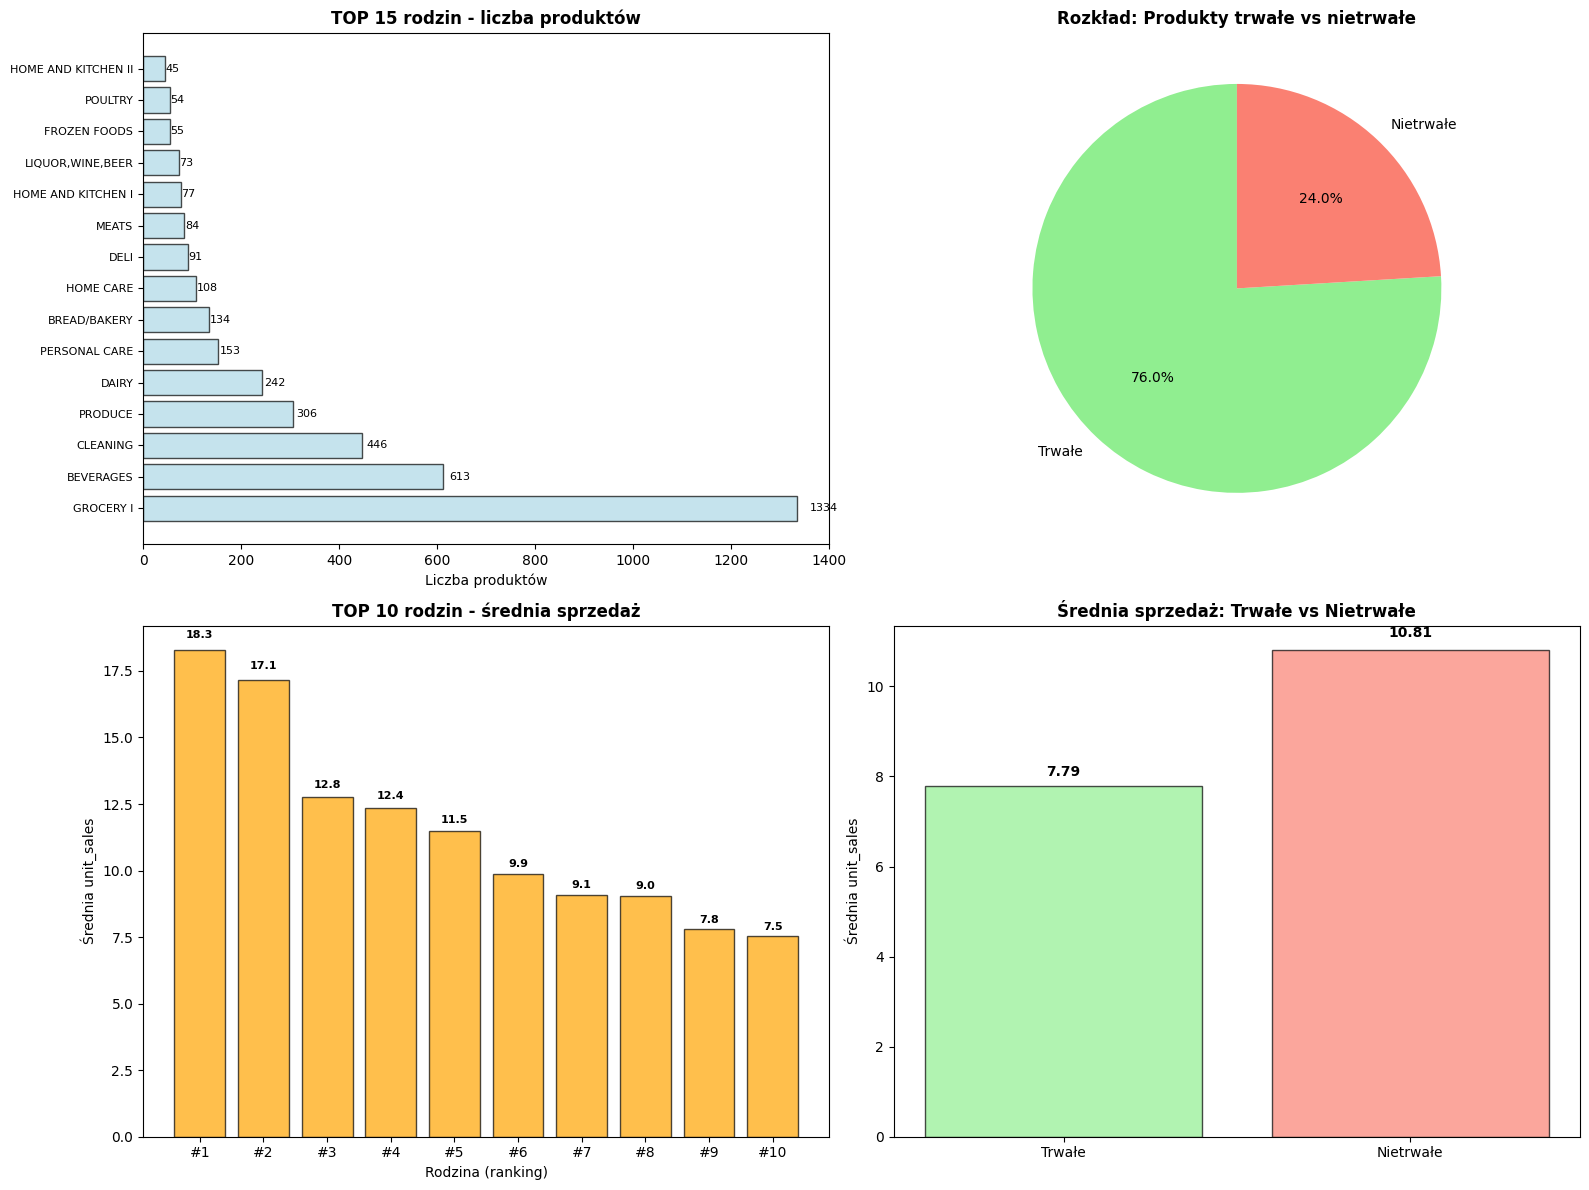

In [13]:
# Analiza kategorii produkt√≥w
print("ANALIZA PRODUKT√ìW:")
print("=" * 30)

print(f"Liczba produkt√≥w: {len(items)}")
print(f"Liczba rodzin: {items['family'].nunique()}")

# TOP rodziny produkt√≥w
family_counts = items['family'].value_counts()
print(f"\nTOP 10 RODZIN PRODUKT√ìW:")
for family, count in family_counts.head(10).items():
    percentage = count / len(items) * 100
    print(f"   {family}: {count} ({percentage:.1f}%)")

# Produkty nietrwa≈Çe
perishable_counts = items['perishable'].value_counts()
print(f"\nPRODUKTY NIETRWA≈ÅE:")
for value, count in perishable_counts.items():
    label = "Nietrwa≈Çe" if value == 1 else "Trwa≈Çe"
    percentage = count / len(items) * 100
    print(f"   {label}: {count} ({percentage:.1f}%)")

# Performance wed≈Çug rodzin produkt√≥w - bez powt√≥rze≈Ñ
print("\nPERFORMANCE WED≈ÅUG RODZIN:")

# Mapowanie
item_family_map = items.set_index('item_nbr')['family'].to_dict()
item_perishable_map = items.set_index('item_nbr')['perishable'].to_dict()

train_family_series = train['item_nbr'].map(item_family_map)

family_performance = train.groupby(train_family_series)['unit_sales'].agg([
    'count', 'mean'
]).round(2)
family_performance.columns = ['Transakcji', '≈örednia']
family_performance = family_performance.sort_values('≈örednia', ascending=False)

print("TOP 10 rodzin (≈õrednia sprzeda≈º):")
print(family_performance.head(10))

# Por√≥wnanie nietrwa≈Çe vs trwa≈Çe
train_perishable_series = train['item_nbr'].map(item_perishable_map)
perishable_performance = train.groupby(train_perishable_series)['unit_sales'].agg([
    'count', 'mean'
]).round(2)
perishable_performance.index = perishable_performance.index.map({0: 'Trwa≈Çe', 1: 'Nietrwa≈Çe'})
perishable_performance.columns = ['Transakcji', '≈örednia']
print(f"\nPOR√ìWNANIE NIETRWA≈ÅE vs TRWA≈ÅE:")
print(perishable_performance)

# WIZUALIZACJE
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. TOP 15 rodzin produkt√≥w - liczba produkt√≥w
top_15_families = family_counts.head(15)
bars1 = ax1.barh(range(len(top_15_families)), top_15_families.values, color='lightblue', alpha=0.7, edgecolor='black')
ax1.set_title('TOP 15 rodzin - liczba produkt√≥w', fontweight='bold')
ax1.set_xlabel('Liczba produkt√≥w')
ax1.set_yticks(range(len(top_15_families)))
ax1.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in top_15_families.index], fontsize=8)
for i, value in enumerate(top_15_families.values):
    ax1.text(value + value*0.02, i, f'{value}', ha='left', va='center', fontsize=8)

# 2. Nietrwa≈Çe vs Trwa≈Çe - liczba produkt√≥w
labels = ['Trwa≈Çe', 'Nietrwa≈Çe']
sizes = [perishable_counts[0], perishable_counts[1]]
colors = ['lightgreen', 'salmon']
wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Rozk≈Çad: Produkty trwa≈Çe vs nietrwa≈Çe', fontweight='bold')

# 3. TOP 10 rodzin - ≈õrednia sprzeda≈º
top_10_performance = family_performance.head(10)
bars3 = ax3.bar(range(len(top_10_performance)), top_10_performance['≈örednia'], color='orange', alpha=0.7, edgecolor='black')
ax3.set_title('TOP 10 rodzin - ≈õrednia sprzeda≈º', fontweight='bold')
ax3.set_ylabel('≈örednia unit_sales')
ax3.set_xlabel('Rodzina (ranking)')
ax3.set_xticks(range(len(top_10_performance)))
ax3.set_xticklabels([f'#{i+1}' for i in range(len(top_10_performance))])
for i, (family, value) in enumerate(zip(top_10_performance.index, top_10_performance['≈örednia'])):
    ax3.text(i, value + value*0.02, f'{value:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4. Por√≥wnanie ≈õredniej sprzeda≈ºy: nietrwa≈Çe vs trwa≈Çe
categories = perishable_performance.index
values = perishable_performance['≈örednia']
colors = ['lightgreen', 'salmon']
bars4 = ax4.bar(categories, values, color=colors, alpha=0.7, edgecolor='black')
ax4.set_title('≈örednia sprzeda≈º: Trwa≈Çe vs Nietrwa≈Çe', fontweight='bold')
ax4.set_ylabel('≈örednia unit_sales')
for bar, value in zip(bars4, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
            f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 8. Oil Price Impact

In [14]:
# Podstawowe statystyki ropy
oil['date'] = pd.to_datetime(oil['date'])
print(f"Zakres dat: {oil['date'].min().date()} ‚Üí {oil['date'].max().date()}")
print(f"Liczba obserwacji: {len(oil)}")

missing_oil = oil['dcoilwtico'].isna().sum()
print(f"BrakujƒÖce warto≈õci: {missing_oil} ({missing_oil/len(oil)*100:.1f}%)")

# Uzupe≈Çnienie brakujƒÖcych warto≈õci
oil['dcoilwtico_filled'] = oil['dcoilwtico'].ffill().bfill()

oil_stats = oil['dcoilwtico_filled'].describe()
print(f"\nSTATYSTYKI CEN ROPY (USD/bary≈Çka):")
print(f"   Min: ${oil_stats['min']:.2f}")
print(f"   Max: ${oil_stats['max']:.2f}")
print(f"   ≈örednia: ${oil_stats['mean']:.2f}")
print(f"   Mediana: ${oil_stats['50%']:.2f}")
print(f"   Odchylenie std: ${oil_stats['std']:.2f}")

# ≈ÅƒÖczenie z danymi sprzeda≈ºy - sample dla szybko≈õci
daily_sales_oil = train.groupby('date')['unit_sales'].agg(['sum', 'mean', 'count']).reset_index()
daily_sales_oil.columns = ['date', 'total_sales', 'avg_sales', 'transactions']

# Merge z cenami ropy
oil_sales = daily_sales_oil.merge(oil[['date', 'dcoilwtico_filled']], on='date', how='inner')
oil_sales = oil_sales.dropna()


Zakres dat: 2013-01-01 ‚Üí 2017-08-31
Liczba obserwacji: 1218
BrakujƒÖce warto≈õci: 43 (3.5%)

STATYSTYKI CEN ROPY (USD/bary≈Çka):
   Min: $26.19
   Max: $110.62
   ≈örednia: $67.69
   Mediana: $53.20
   Odchylenie std: $25.63


In [15]:

# KORELACJE
corr_total = oil_sales['dcoilwtico_filled'].corr(oil_sales['total_sales'])
corr_avg = oil_sales['dcoilwtico_filled'].corr(oil_sales['avg_sales'])

print(f"üìä KORELACJE CENA ROPY ‚Üî SPRZEDA≈ª:")
print(f"   Cena ropy ‚Üî Ca≈Çkowita sprzeda≈º:  {corr_total:+.4f}")
print(f"   Cena ropy ‚Üî ≈örednia sprzeda≈º:    {corr_avg:+.4f}")

# ANALIZA OKRES√ìW wysokich i niskich cen
oil_q1 = oil_sales['dcoilwtico_filled'].quantile(0.25)
oil_q3 = oil_sales['dcoilwtico_filled'].quantile(0.75)

high_oil_periods = oil_sales[oil_sales['dcoilwtico_filled'] > oil_q3]
low_oil_periods = oil_sales[oil_sales['dcoilwtico_filled'] < oil_q1]

print(f"\nüîç ANALIZA OKRES√ìW CENOWYCH:")
print(f"   Q1 (niskie ceny): <${oil_q1:.2f} - {len(low_oil_periods)} dni")
print(f"   Q4 (wysokie):     >${oil_q3:.2f} - {len(high_oil_periods)} dni")

# Wp≈Çyw na sprzeda≈º
if len(high_oil_periods) > 0 and len(low_oil_periods) > 0:
    high_sales_avg = high_oil_periods['avg_sales'].mean()
    low_sales_avg = low_oil_periods['avg_sales'].mean()
    high_vs_low = (high_sales_avg - low_sales_avg) / low_sales_avg * 100
    
    print(f"\nüí∞ WP≈ÅYW CEN ROPY NA SPRZEDA≈ª:")
    print(f"   ≈örednia sprzeda≈º przy niskich cenach:  {low_sales_avg:.3f}")
    print(f"   ≈örednia sprzeda≈º przy wysokich cenach: {high_sales_avg:.3f}")
    print(f"   R√≥≈ºnica wysokie vs niskie: {high_vs_low:+.1f}%")

üìä KORELACJE CENA ROPY ‚Üî SPRZEDA≈ª:
   Cena ropy ‚Üî Ca≈Çkowita sprzeda≈º:  -0.6900
   Cena ropy ‚Üî ≈örednia sprzeda≈º:    +0.1013

üîç ANALIZA OKRES√ìW CENOWYCH:
   Q1 (niskie ceny): <$46.41 - 301 dni
   Q4 (wysokie):     >$95.79 - 301 dni

üí∞ WP≈ÅYW CEN ROPY NA SPRZEDA≈ª:
   ≈örednia sprzeda≈º przy niskich cenach:  7.661
   ≈örednia sprzeda≈º przy wysokich cenach: 7.968
   R√≥≈ºnica wysokie vs niskie: +4.0%


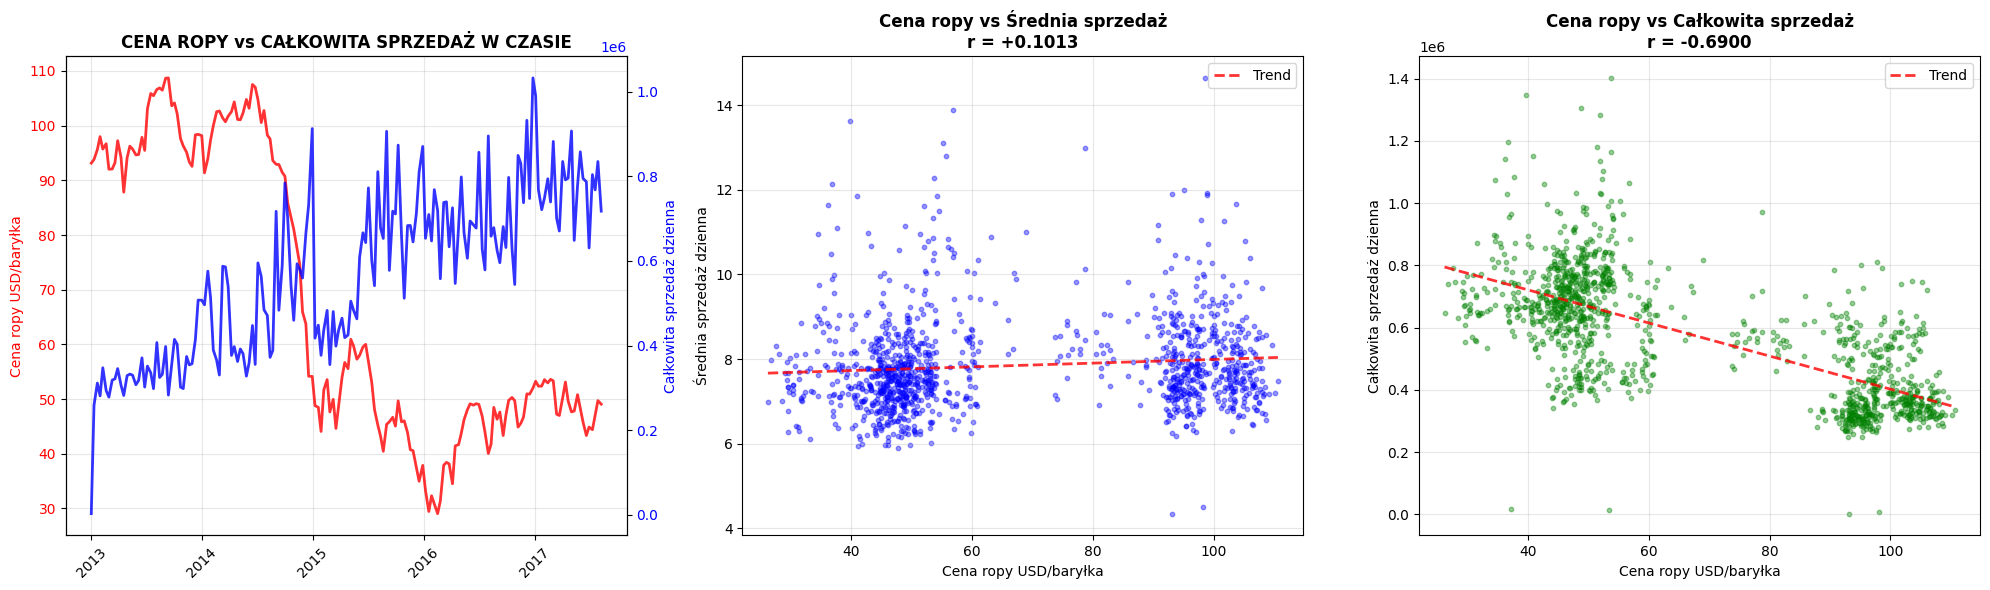

‚úÖ Korelacja ceny ropy i ≈õredniej sprzeda≈ºy: +0.1013
‚úÖ Korelacja ceny ropy i ca≈Çkowitej sprzeda≈ºy: -0.6900


In [16]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. G≈Å√ìWNY WYKRES: Cena ropy i sprzeda≈º na jednym wykresie (dual axis)
ax1_twin = ax1.twinx()

# Sample data dla szybko≈õci (co 7 dni)
oil_sample = oil_sales[::7]  

# Cena ropy (o≈õ lewa)
ax1.plot(oil_sample['date'], oil_sample['dcoilwtico_filled'], 
         color='red', alpha=0.8, linewidth=2, label='Cena ropy (USD/bary≈Çka)')
ax1.set_ylabel('Cena ropy USD/bary≈Çka', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Ca≈Çkowita sprzeda≈º (o≈õ prawa)
ax1_twin.plot(oil_sample['date'], oil_sample['total_sales'], 
              color='blue', alpha=0.8, linewidth=2, label='Ca≈Çkowita sprzeda≈º')
ax1_twin.set_ylabel('Ca≈Çkowita sprzeda≈º dzienna', color='blue')
ax1_twin.tick_params(axis='y', labelcolor='blue')

ax1.set_title('CENA ROPY vs CA≈ÅKOWITA SPRZEDA≈ª W CZASIE', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Scatter plot: Cena ropy vs ≈örednia sprzeda≈º
ax2.scatter(oil_sales['dcoilwtico_filled'], oil_sales['avg_sales'], alpha=0.4, s=10, color='blue')
ax2.set_title(f'Cena ropy vs ≈örednia sprzeda≈º\nr = {corr_avg:+.4f}', fontweight='bold')
ax2.set_xlabel('Cena ropy USD/bary≈Çka')
ax2.set_ylabel('≈örednia sprzeda≈º dzienna')
ax2.grid(True, alpha=0.3)

# Linia trendu dla ≈õredniej sprzeda≈ºy
if len(oil_sales) > 2:
    z = np.polyfit(oil_sales['dcoilwtico_filled'], oil_sales['avg_sales'], 1)
    p = np.poly1d(z)
    x_trend = oil_sales['dcoilwtico_filled'].sort_values()
    ax2.plot(x_trend, p(x_trend), "r--", linewidth=2, alpha=0.8, label='Trend')
    ax2.legend()

# 3. NEW: Scatter plot: Cena ropy vs Ca≈Çkowita sprzeda≈º
ax3.scatter(oil_sales['dcoilwtico_filled'], oil_sales['total_sales'], alpha=0.4, s=10, color='green')
ax3.set_title(f'Cena ropy vs Ca≈Çkowita sprzeda≈º\nr = {corr_total:+.4f}', fontweight='bold')
ax3.set_xlabel('Cena ropy USD/bary≈Çka')
ax3.set_ylabel('Ca≈Çkowita sprzeda≈º dzienna')
ax3.grid(True, alpha=0.3)

# Linia trendu dla ca≈Çkowitej sprzeda≈ºy
if len(oil_sales) > 2:
    z_total = np.polyfit(oil_sales['dcoilwtico_filled'], oil_sales['total_sales'], 1)
    p_total = np.poly1d(z_total)
    ax3.plot(x_trend, p_total(x_trend), "r--", linewidth=2, alpha=0.8, label='Trend')
    ax3.legend()

plt.tight_layout()
plt.show()

print(f"‚úÖ Korelacja ceny ropy i ≈õredniej sprzeda≈ºy: {corr_avg:+.4f}")
print(f"‚úÖ Korelacja ceny ropy i ca≈Çkowitej sprzeda≈ºy: {corr_total:+.4f}")

## 9. Holidays Analysis

In [18]:
print("ANALIZA ≈öWIƒÑT I WYDARZE≈É:")
print("=" * 40)

holidays['date'] = pd.to_datetime(holidays['date'])
print(f"Zakres dat: {holidays['date'].min()} ‚Üí {holidays['date'].max()}")
print(f"Liczba wydarze≈Ñ: {len(holidays)}")

print(f"\nTYPY WYDARZE≈É:")
type_counts = holidays['type'].value_counts()
for event_type, count in type_counts.items():
    percentage = count / len(holidays) * 100
    print(f"   {event_type:15}: {count:3} ({percentage:4.1f}%)")

print(f"\nLOKALIZACJA (locale):")
locale_counts = holidays['locale'].value_counts()
print(f"   National: {locale_counts.get('National', 0)}")
print(f"   Local:    {locale_counts.get('Local', 0)}")
print(f"   Regional: {locale_counts.get('Regional', 0)}")

print(f"\n≈öWIƒòTA PRZENIESIONE (transferred):")
transferred_counts = holidays['transferred'].value_counts()
for value, count in transferred_counts.items():
    print(f"   {str(value):5}: {count}")

print(f"\nNAJCZƒòSTSZE ≈öWIƒòTA (TOP 10):")
description_counts = holidays['description'].value_counts().head(10)
for desc, count in description_counts.items():
    print(f"   {desc[:30]:30}: {count}")

# Analiza wp≈Çywu ≈õwiƒÖt na sprzeda≈º
if 'train' in globals():
    # ≈ÅƒÖczenie ≈õwiƒÖt z danymi sprzeda≈ºy
    holidays_national = holidays[holidays['locale'] == 'National'].copy()
    
    # Dodajemy informacjƒô o ≈õwiƒôcie do danych treningowych
    train_with_holidays = train.merge(
        holidays_national[['date', 'type', 'description']], 
        on='date', 
        how='left'
    )
    
    # Tworzymy binary feature dla ≈õwiƒÖt
    train_with_holidays['is_holiday'] = ~train_with_holidays['type'].isna()
    
    print(f"\nüìà WP≈ÅYW ≈öWIƒÑT NA SPRZEDA≈ª:")
    holiday_impact = train_with_holidays.groupby('is_holiday')['unit_sales'].agg([
        'count', 'mean', 'median', 'std'
    ]).round(3)
    
    holiday_impact.index = holiday_impact.index.map({False: 'Zwyk≈Çy dzie≈Ñ', True: '≈öwiƒôto'})
    print(holiday_impact)
    
    # Test statystyczny
    holiday_sales = train_with_holidays[train_with_holidays['is_holiday'] == True]['unit_sales']
    regular_sales = train_with_holidays[train_with_holidays['is_holiday'] == False]['unit_sales']
    
    if len(holiday_sales) > 0 and len(regular_sales) > 0:
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(holiday_sales, regular_sales)
        print(f"\nüß™ Test t-studenta (≈õwiƒôta vs zwyk≈Çe dni):")
        print(f"   t-statistic: {t_stat:.3f}")
        print(f"   p-value: {p_value:.6f}")
        print(f"   R√≥≈ºnica istotna statystycznie: {'TAK' if p_value < 0.05 else 'NIE'}")
        
        if correlation > 0:
            lift = (holiday_sales.mean() - regular_sales.mean()) / regular_sales.mean() * 100
            print(f"\nLIFT OD ≈öWIƒÑT: {lift:+.1f}%")

ANALIZA ≈öWIƒÑT I WYDARZE≈É:
Zakres dat: 2012-03-02 00:00:00 ‚Üí 2017-12-26 00:00:00
Liczba wydarze≈Ñ: 350

TYPY WYDARZE≈É:
   Holiday        : 221 (63.1%)
   Event          :  56 (16.0%)
   Additional     :  51 (14.6%)
   Transfer       :  12 ( 3.4%)
   Bridge         :   5 ( 1.4%)
   Work Day       :   5 ( 1.4%)

LOKALIZACJA (locale):
   National: 174
   Local:    152
   Regional: 24

≈öWIƒòTA PRZENIESIONE (transferred):
   False: 338
   True : 12

NAJCZƒòSTSZE ≈öWIƒòTA (TOP 10):
   Carnaval                      : 10
   Fundacion de Ibarra           : 7
   Fundacion de Cuenca           : 7
   Cantonizacion de Libertad     : 6
   Cantonizacion de Riobamba     : 6
   Cantonizacion del Puyo        : 6
   Fundacion de Manta            : 6
   Cantonizacion de Guaranda     : 6
   Provincializacion de Imbabura : 6
   Fundacion de Machala          : 6

üìà WP≈ÅYW ≈öWIƒÑT NA SPRZEDA≈ª:

üìà WP≈ÅYW ≈öWIƒÑT NA SPRZEDA≈ª:
                  count   mean  median        std
is_holiday            

## 10. Transactions Analysis

ANALIZA TRANSAKCJI:
Zakres dat: 2013-01-01 00:00:00 ‚Üí 2017-08-15 00:00:00
Liczba rekord√≥w: 83488
Liczba sklep√≥w: 54

STATYSTYKI LICZBY TRANSAKCJI:
   count: 83488
   mean: 1695
   std: 963
   min: 5
   25%: 1046
   50%: 1393
   75%: 2079
   max: 8359

TOP 10 SKLEP√ìW (wed≈Çug ≈õredniej liczby transakcji):
              Suma  ≈örednia  Mediana  Maksimum
store_nbr                                     
44         7273093   4337.0   4170.0      8359
47         6535810   3897.0   3685.0      7727
45         6201115   3698.0   3515.0      7305
46         5990113   3572.0   3230.0      8001
3          5366350   3202.0   3100.0      6085
48         5107785   3046.0   2705.0      7044
8          4637971   2767.0   2740.0      5261
49         4574103   2728.0   2671.0      6600
50         4384444   2614.0   2448.0      5456
11         3972488   2370.0   2300.0      5018

üìä KORELACJA TRANSAKCJE ‚Üî SPRZEDA≈ª: 0.6765
   Interpretacja: silna korelacja

üìä KORELACJA TRANSAKCJE ‚Üî SPRZEDA≈ª:

ANALIZA TRANSAKCJI:
Zakres dat: 2013-01-01 00:00:00 ‚Üí 2017-08-15 00:00:00
Liczba rekord√≥w: 83488
Liczba sklep√≥w: 54

STATYSTYKI LICZBY TRANSAKCJI:
   count: 83488
   mean: 1695
   std: 963
   min: 5
   25%: 1046
   50%: 1393
   75%: 2079
   max: 8359

TOP 10 SKLEP√ìW (wed≈Çug ≈õredniej liczby transakcji):
              Suma  ≈örednia  Mediana  Maksimum
store_nbr                                     
44         7273093   4337.0   4170.0      8359
47         6535810   3897.0   3685.0      7727
45         6201115   3698.0   3515.0      7305
46         5990113   3572.0   3230.0      8001
3          5366350   3202.0   3100.0      6085
48         5107785   3046.0   2705.0      7044
8          4637971   2767.0   2740.0      5261
49         4574103   2728.0   2671.0      6600
50         4384444   2614.0   2448.0      5456
11         3972488   2370.0   2300.0      5018

üìä KORELACJA TRANSAKCJE ‚Üî SPRZEDA≈ª: 0.6765
   Interpretacja: silna korelacja

üìä KORELACJA TRANSAKCJE ‚Üî SPRZEDA≈ª:

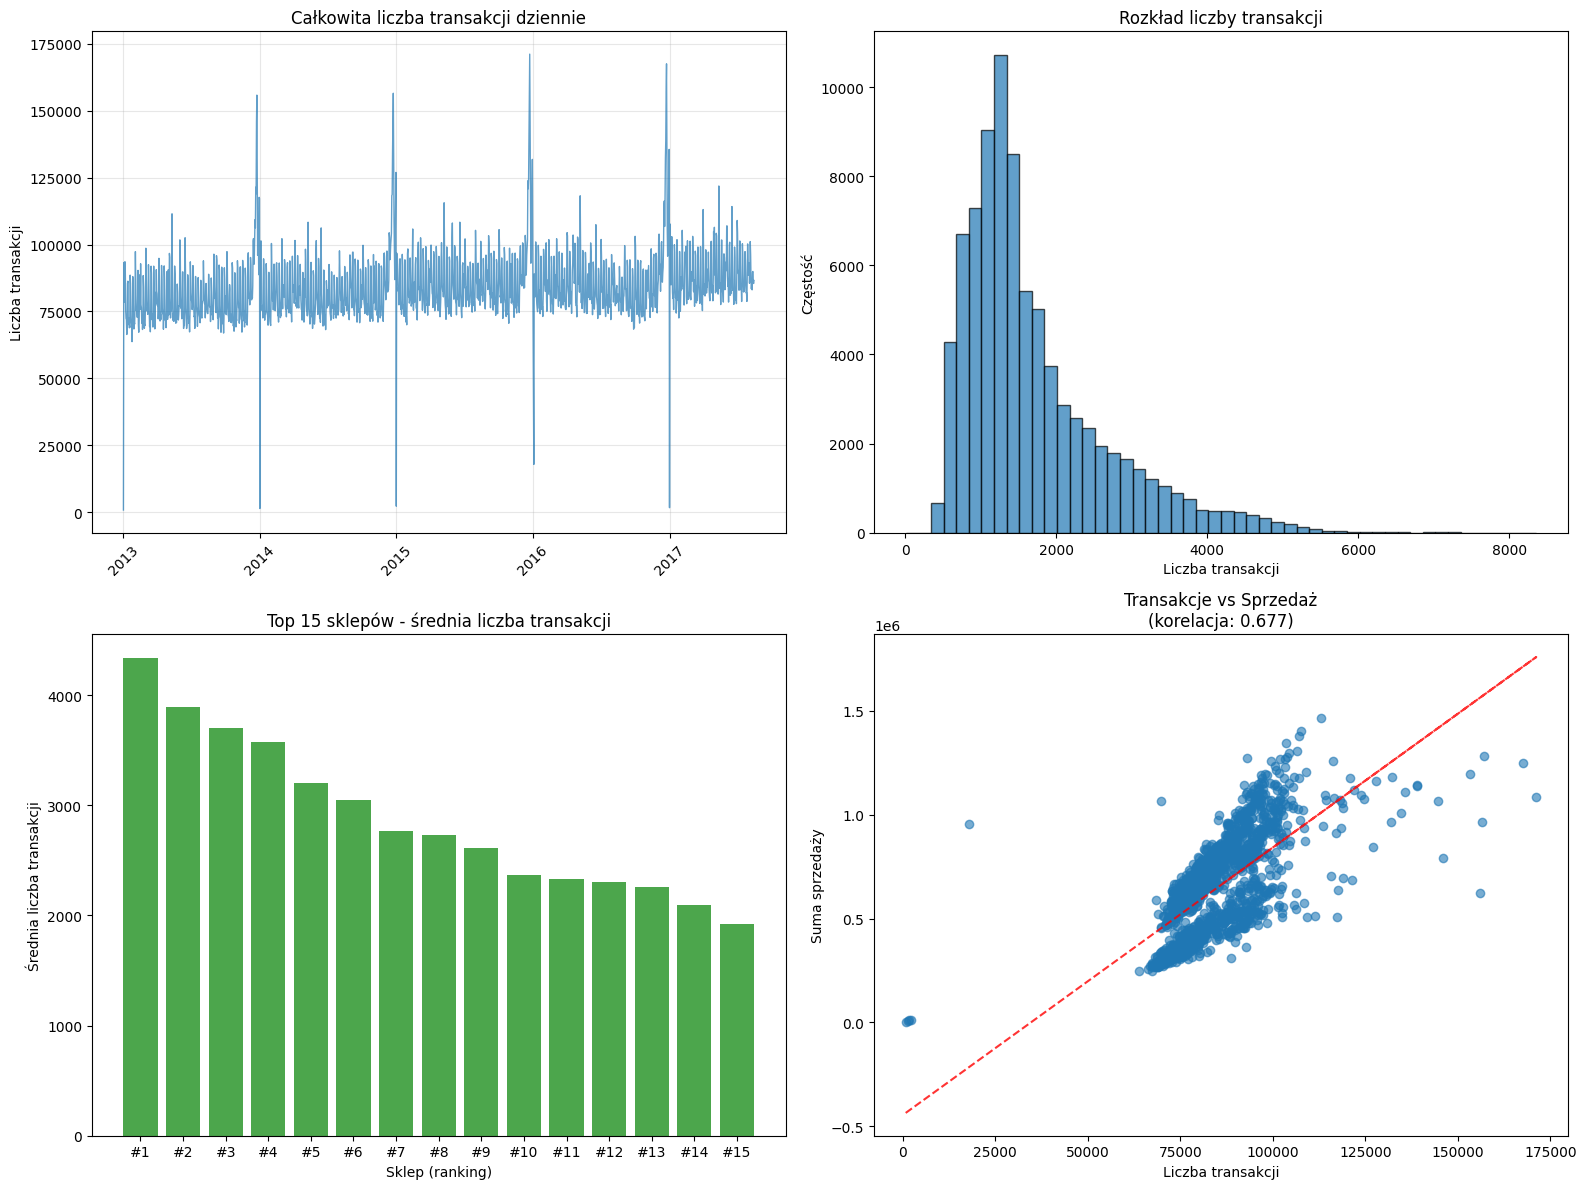


INSIGHTS:
   ≈örednia dzienna liczba transakcji: 84114
   Najwy≈ºsza dzienna liczba: 171,169
   Najni≈ºsza dzienna liczba: 770
   Odchylenie standardowe: 963

SEZONOWO≈öƒÜ TRANSAKCJI:
   Pon: 1636 ≈õrednio
   Wt: 1601 ≈õrednio
   ≈ör: 1621 ≈õrednio
   Czw: 1550 ≈õrednio
   Pt: 1654 ≈õrednio
   Sob: 1953 ≈õrednio
   Nie: 1847 ≈õrednio

   Najlepszy dzie≈Ñ: Sob (1953)
   Najgorszy dzie≈Ñ: Czw (1550)


In [19]:
print("ANALIZA TRANSAKCJI:")
print("=" * 30)

transactions['date'] = pd.to_datetime(transactions['date'])
print(f"Zakres dat: {transactions['date'].min()} ‚Üí {transactions['date'].max()}")
print(f"Liczba rekord√≥w: {len(transactions)}")
print(f"Liczba sklep√≥w: {transactions['store_nbr'].nunique()}")

print(f"\nSTATYSTYKI LICZBY TRANSAKCJI:")
trans_stats = transactions['transactions'].describe()
for stat, value in trans_stats.items():
    print(f"   {stat}: {value:.0f}")

print(f"\nTOP 10 SKLEP√ìW (wed≈Çug ≈õredniej liczby transakcji):")
store_transactions = transactions.groupby('store_nbr')['transactions'].agg([
    'sum', 'mean', 'median', 'max'
]).round(0)
store_transactions.columns = ['Suma', '≈örednia', 'Mediana', 'Maksimum']
store_transactions = store_transactions.sort_values('≈örednia', ascending=False)
print(store_transactions.head(10))

# Analiza trend√≥w czasowych transakcji
daily_trans = transactions.groupby('date')['transactions'].sum().reset_index()

# Korelacja transakcje vs sprzeda≈º (je≈õli dane dostƒôpne)
if 'train' in globals():
    # ≈ÅƒÖczenie z danymi sprzeda≈ºy
    daily_sales_trans = train.groupby('date')['unit_sales'].sum().reset_index()
    trans_sales_corr = daily_trans.merge(daily_sales_trans, on='date', how='inner')
    
    if len(trans_sales_corr) > 10:
        correlation = trans_sales_corr['transactions'].corr(trans_sales_corr['unit_sales'])
        print(f"\nüìä KORELACJA TRANSAKCJE ‚Üî SPRZEDA≈ª: {correlation:.4f}")
        
        # Interpretacja
        if abs(correlation) > 0.7:
            interp = "bardzo silna"
        elif abs(correlation) > 0.5:
            interp = "silna" 
        elif abs(correlation) > 0.3:
            interp = "umiarkowana"
        else:
            interp = "s≈Çaba"
        print(f"   Interpretacja: {interp} korelacja")

# Wizualizacja transakcji
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Trend transakcji w czasie
ax1.plot(daily_trans['date'], daily_trans['transactions'], alpha=0.7, linewidth=1)
ax1.set_title('Ca≈Çkowita liczba transakcji dziennie')
ax1.set_ylabel('Liczba transakcji')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Histogram liczby transakcji
ax2.hist(transactions['transactions'], bins=50, alpha=0.7, edgecolor='black')
ax2.set_title('Rozk≈Çad liczby transakcji')
ax2.set_xlabel('Liczba transakcji')
ax2.set_ylabel('Czƒôsto≈õƒá')

# 3. Top 15 sklep√≥w - ≈õrednia liczba transakcji
top_stores = store_transactions.head(15)['≈örednia']
ax3.bar(range(len(top_stores)), top_stores.values, alpha=0.7, color='green')
ax3.set_title('Top 15 sklep√≥w - ≈õrednia liczba transakcji')
ax3.set_xlabel('Sklep (ranking)')
ax3.set_ylabel('≈örednia liczba transakcji')
ax3.set_xticks(range(len(top_stores)))
ax3.set_xticklabels([f'#{i+1}' for i in range(len(top_stores))])

# 4. Korelacja transakcje vs sprzeda≈º (je≈õli dostƒôpne)
if 'trans_sales_corr' in locals() and len(trans_sales_corr) > 10:
    ax4.scatter(trans_sales_corr['transactions'], trans_sales_corr['unit_sales'], alpha=0.6)
    ax4.set_title(f'Transakcje vs Sprzeda≈º\n(korelacja: {correlation:.3f})')
    ax4.set_xlabel('Liczba transakcji')
    ax4.set_ylabel('Suma sprzeda≈ºy')
    
    # Linia trendu
    z = np.polyfit(trans_sales_corr['transactions'], trans_sales_corr['unit_sales'], 1)
    p = np.poly1d(z)
    ax4.plot(trans_sales_corr['transactions'], p(trans_sales_corr['transactions']), "r--", alpha=0.8)
else:
    ax4.text(0.5, 0.5, 'Dane sprzeda≈ºy\nnie dostƒôpne', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Korelacja niedostƒôpna')

plt.tight_layout()
plt.show()

print(f"\nINSIGHTS:")
print(f"   ≈örednia dzienna liczba transakcji: {daily_trans['transactions'].mean():.0f}")
print(f"   Najwy≈ºsza dzienna liczba: {daily_trans['transactions'].max():,}")
print(f"   Najni≈ºsza dzienna liczba: {daily_trans['transactions'].min():,}")
print(f"   Odchylenie standardowe: {transactions['transactions'].std():.0f}")

# Dodaj kolumny czasowe do analizy sezonowo≈õci
transactions['dayofweek'] = transactions['date'].dt.dayofweek

print(f"\nSEZONOWO≈öƒÜ TRANSAKCJI:")
dow_trans = transactions.groupby('dayofweek')['transactions'].mean()
day_names = ['Pon', 'Wt', '≈ör', 'Czw', 'Pt', 'Sob', 'Nie']

for i, avg_trans in enumerate(dow_trans):
    print(f"   {day_names[i]}: {avg_trans:.0f} ≈õrednio")

best_day = day_names[dow_trans.idxmax()]
worst_day = day_names[dow_trans.idxmin()]
print(f"\n   Najlepszy dzie≈Ñ: {best_day} ({dow_trans.max():.0f})")
print(f"   Najgorszy dzie≈Ñ: {worst_day} ({dow_trans.min():.0f})")

## 9.5. Promotions vs Holidays

In [11]:
# ANALIZA KORELACJI: PROMOCJE vs ≈öWIƒòTA
if 'train' in globals() and 'holidays' in globals():
    try:
        # Memory-safe processing: limit dataset size if needed
        if len(train) > 1000000:  # If train is too large, sample it
            train_sample = train.sample(n=1000000, random_state=42)
        else:
            train_sample = train.copy()
        
        national_holidays = holidays[holidays['locale'] == 'National'].copy()
        national_holidays['date'] = pd.to_datetime(national_holidays['date'])
        
        train_promo_holiday = train_sample.merge(
            national_holidays[['date', 'type', 'description', 'transferred']], 
            on='date', how='left'
        )
        
        train_promo_holiday['is_holiday'] = ~train_promo_holiday['type'].isna()
        train_promo_holiday['is_promotion'] = train_promo_holiday['onpromotion'] == True
        
        clean_data = train_promo_holiday.dropna(subset=['onpromotion'])
        
        crosstab = pd.crosstab(
            clean_data['is_holiday'], 
            clean_data['is_promotion'], 
            margins=True, normalize='index'
        )
        
        promo_rate_regular = clean_data[~clean_data['is_holiday']]['is_promotion'].mean()
        promo_rate_holiday = clean_data[clean_data['is_holiday']]['is_promotion'].mean()
        
        if promo_rate_regular > 0:
            promo_lift_holidays = (promo_rate_holiday - promo_rate_regular) / promo_rate_regular * 100
            
        # Clean up large variables to save memory
        del train_promo_holiday
        if len(train) > 1000000:
            del train_sample
            
    except MemoryError:
        print("Memory error - using smaller sample")
        train_sample = train.sample(n=100000, random_state=42)

else:
    clean_data = None

üìä ANALIZA PROMOCJI vs ≈öWIƒòTA:
   Procent promocji w zwyk≈Çe dni: 7.44%
   Procent promocji w ≈õwiƒôta:     8.61%
   Wzrost promocji w ≈õwiƒôta:      +15.75%


üìä U≈ºywam pr√≥bkƒô 500,000 rekord√≥w do wizualizacji

üõí ANALIZA TRANSAKCJI W OKRESACH ≈öWIƒÑTECZNYCH:
   ≈örednie transakcje w zwyk≈Çe dni:        1749
   ≈örednie transakcje w okres ≈õwiƒÖteczny:  1673
   R√≥≈ºnica bezwzglƒôdna:                    -76
   R√≥≈ºnica procentowa:                     -4.3%
   Liczba dni ≈õwiƒÖtecznych: 97
   Liczba dni regularnych:  194

üìà ANALIZA SPRZEDA≈ªY - ≈öWIƒòTA vs ZWYK≈ÅE DNI:
   ≈örednia sprzeda≈º w zwyk≈Çe dni:      8.29 szt/produkt
   ≈örednia sprzeda≈º w dni ≈õwiƒÖteczne:  9.36 szt/produkt
   R√≥≈ºnica procentowa:                 +12.9%
   Liczba rekord√≥w ≈õwiƒÖtecznych: 49,918
   Liczba rekord√≥w regularnych:  10,000

üõí ANALIZA TRANSAKCJI W OKRESACH ≈öWIƒÑTECZNYCH:
   ≈örednie transakcje w zwyk≈Çe dni:        1749
   ≈örednie transakcje w okres ≈õwiƒÖteczny:  1673
   R√≥≈ºnica bezwzglƒôdna:                    -76
   R√≥≈ºnica procentowa:                     -4.3%
   Liczba dni ≈õwiƒÖtecznych: 97
   Liczba dni regularnych:  194

ü

üìä U≈ºywam pr√≥bkƒô 500,000 rekord√≥w do wizualizacji

üõí ANALIZA TRANSAKCJI W OKRESACH ≈öWIƒÑTECZNYCH:
   ≈örednie transakcje w zwyk≈Çe dni:        1749
   ≈örednie transakcje w okres ≈õwiƒÖteczny:  1673
   R√≥≈ºnica bezwzglƒôdna:                    -76
   R√≥≈ºnica procentowa:                     -4.3%
   Liczba dni ≈õwiƒÖtecznych: 97
   Liczba dni regularnych:  194

üìà ANALIZA SPRZEDA≈ªY - ≈öWIƒòTA vs ZWYK≈ÅE DNI:
   ≈örednia sprzeda≈º w zwyk≈Çe dni:      8.29 szt/produkt
   ≈örednia sprzeda≈º w dni ≈õwiƒÖteczne:  9.36 szt/produkt
   R√≥≈ºnica procentowa:                 +12.9%
   Liczba rekord√≥w ≈õwiƒÖtecznych: 49,918
   Liczba rekord√≥w regularnych:  10,000

üõí ANALIZA TRANSAKCJI W OKRESACH ≈öWIƒÑTECZNYCH:
   ≈örednie transakcje w zwyk≈Çe dni:        1749
   ≈örednie transakcje w okres ≈õwiƒÖteczny:  1673
   R√≥≈ºnica bezwzglƒôdna:                    -76
   R√≥≈ºnica procentowa:                     -4.3%
   Liczba dni ≈õwiƒÖtecznych: 97
   Liczba dni regularnych:  194

ü

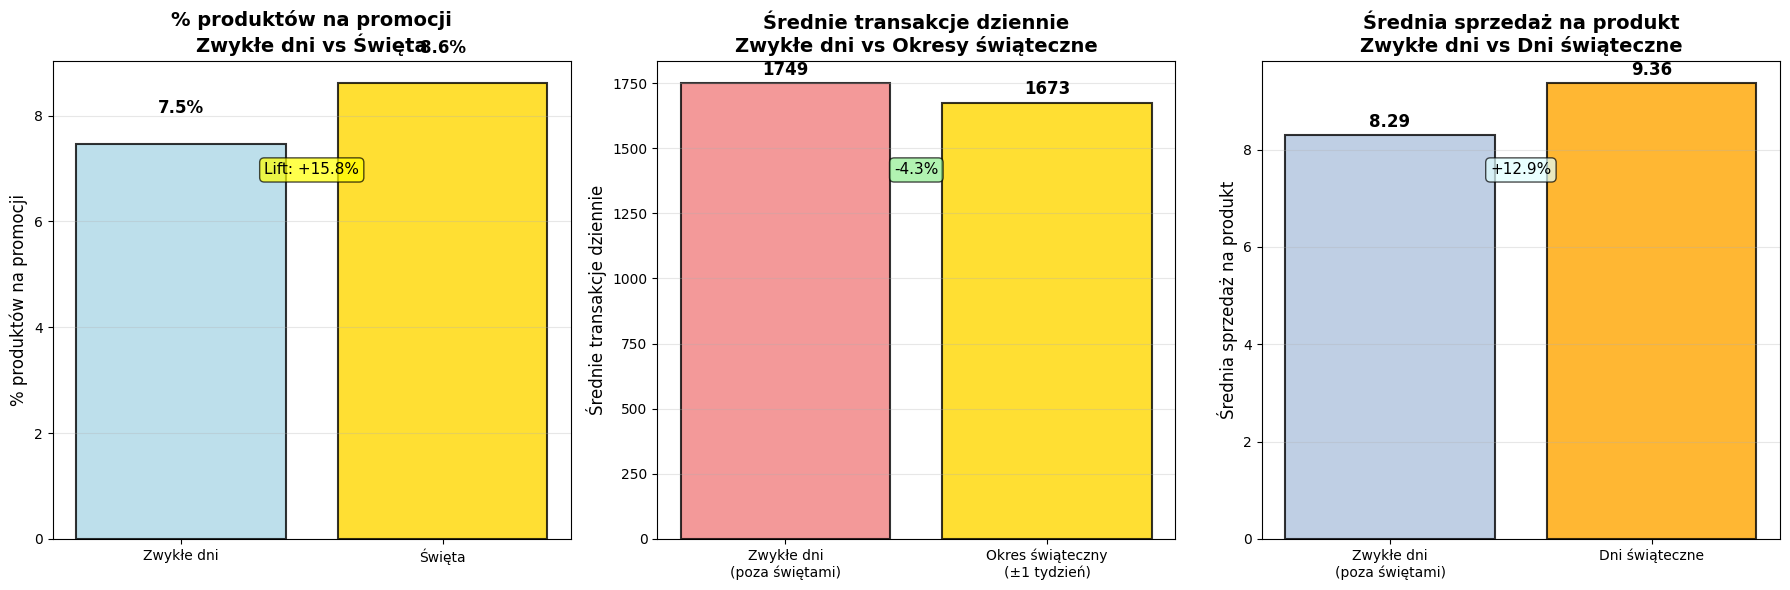

In [ ]:
# WIZUALIZACJE: PROMOCJE vs ≈öWIƒòTA i SPRZEDA≈ª w OKRESACH ≈öWIƒÑTECZNYCH
if 'clean_data' in locals() and len(clean_data) > 0:
        # Memory-safe visualization for large datasets
        if len(clean_data) > 500000:
            viz_data = clean_data.sample(n=500000, random_state=42)
        else:
            viz_data = clean_data.copy()
            
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
        
        # WYKRES 1: Podstawowe por√≥wnanie promocji
        promo_comparison = viz_data.groupby('is_holiday')['is_promotion'].mean() * 100
        categories = ['Zwyk≈Çe dni', '≈öwiƒôta']
        
        val_false = promo_comparison.get(False, 0) if False in promo_comparison.index else 0
        val_true = promo_comparison.get(True, 0) if True in promo_comparison.index else 0
        values = [val_false, val_true]
        colors = ['lightblue', 'gold']
        
        bars1 = ax1.bar(categories, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
        ax1.set_title('% produkt√≥w na promocji\nZwyk≈Çe dni vs ≈öwiƒôta', fontsize=14, fontweight='bold')
        ax1.set_ylabel('% produkt√≥w na promocji', fontsize=12)
        ax1.grid(axis='y', alpha=0.3)
        
        for bar, value in zip(bars1, values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        if 'promo_lift_holidays' in locals():
            ax1.text(0.5, max(values) * 0.8, f'Lift: {promo_lift_holidays:+.1f}%', 
                    ha='center', transform=ax1.transData, fontsize=11,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        # WYKRES 2: ≈öREDNIE TRANSAKCJE - Okresy ≈õwiƒÖteczne (¬±tydzie≈Ñ) vs zwyk≈Çe dni
        if 'transactions' in locals() and len(transactions) > 0 and 'national_holidays' in locals():
            # Analiza transakcji na poziomie dni
            trans_data = transactions.copy()
            trans_data['date'] = pd.to_datetime(trans_data['date'])
            
            # Definicja okres√≥w ≈õwiƒÖtecznych
            holiday_trans = []
            regular_trans = []
            
            all_holiday_dates = set()
            for _, holiday in national_holidays.head(20).iterrows():
                holiday_date = holiday['date']
                
                # Okres ≈õwiƒÖteczny: ≈õwiƒôto +/- 7 dni
                for offset in range(-7, 8):
                    check_date = holiday_date + pd.Timedelta(days=offset)
                    all_holiday_dates.add(check_date)
                    day_trans = trans_data[trans_data['date'] == check_date]
                    if len(day_trans) > 0:
                        avg_daily_trans = day_trans['transactions'].mean()
                        holiday_trans.append(avg_daily_trans)
            
            # Okres regularny
            regular_days = trans_data[~trans_data['date'].isin(all_holiday_dates)]
            if len(regular_days) > 100:
                regular_sample = regular_days.sample(n=min(len(holiday_trans)*2, 500), random_state=42)
                regular_trans = regular_sample['transactions'].tolist()
            
            if holiday_trans and regular_trans:
                holiday_avg_trans = np.mean(holiday_trans)
                regular_avg_trans = np.mean(regular_trans)
                
                period_categories = ['Zwyk≈Çe dni\n(poza ≈õwiƒôtami)', 'Okres ≈õwiƒÖteczny\n(¬±1 tydzie≈Ñ)']
                period_values = [regular_avg_trans, holiday_avg_trans]
                period_colors = ['lightcoral', 'gold']
                
                bars2 = ax2.bar(period_categories, period_values, color=period_colors, 
                               alpha=0.8, edgecolor='black', linewidth=1.5)
                ax2.set_title('≈örednie transakcje dziennie\nZwyk≈Çe dni vs Okresy ≈õwiƒÖteczne', fontsize=14, fontweight='bold')
                ax2.set_ylabel('≈örednie transakcje dziennie', fontsize=12)
                ax2.grid(axis='y', alpha=0.3)
                
                # Dodaj warto≈õci na s≈Çupkach
                for bar, value in zip(bars2, period_values):
                    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(period_values)*0.01,
                            f'{value:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
                
                # Dodaj r√≥≈ºnicƒô procentowƒÖ
                percentage_diff = ((holiday_avg_trans - regular_avg_trans) / regular_avg_trans) * 100
                ax2.text(0.5, max(period_values) * 0.8, f'{percentage_diff:+.1f}%', 
                        ha='center', transform=ax2.transData, fontsize=11,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
                
            else:
                ax2.text(0.5, 0.5, 'Za ma≈Ço danych\no transakcjach', 
                        ha='center', va='center', transform=ax2.transAxes, fontsize=12)
                ax2.set_title('Analiza transakcji niedostƒôpna')
        else:
            ax2.text(0.5, 0.5, 'Brak danych\no transakcjach', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Analiza transakcji niedostƒôpna')
        
        
        # WYKRES 3: CA≈ÅKOWITA/≈öREDNIA SPRZEDA≈ª - Okresy ≈õwiƒÖteczne vs zwyk≈Çe dni
        if 'clean_data' in locals() and len(clean_data) > 0:
            # Analiza sprzeda≈ºy bezpo≈õrednio z clean_data
            holiday_sales = []
            regular_sales = []
            
            # Okresy ≈õwiƒÖteczne
            holiday_data = clean_data[clean_data['is_holiday'] == True]
            if len(holiday_data) > 0:
                holiday_sales = holiday_data['unit_sales'].tolist()
            
            # Okresy regularne  
            regular_data = clean_data[clean_data['is_holiday'] == False]
            if len(regular_data) > 0:
                # Sample dla wydajno≈õci
                if len(regular_data) > 10000:
                    regular_sample = regular_data.sample(n=10000, random_state=42)
                else:
                    regular_sample = regular_data
                regular_sales = regular_sample['unit_sales'].tolist()
            
            if holiday_sales and regular_sales:
                # Oblicz ≈õrednie i sumy
                holiday_avg_sales = np.mean(holiday_sales) 
                regular_avg_sales = np.mean(regular_sales)
                
                holiday_total_sales = np.sum(holiday_sales)
                regular_total_sales = np.sum(regular_sales)
                
                # Wybierz metrykƒô (mo≈ºna zmieniƒá)
                metric = 'avg'  # 'avg' dla ≈õredniej, 'total' dla ca≈Çkowitej
                
                if metric == 'total':
                    sales_values = [regular_total_sales, holiday_total_sales]
                    sales_name = 'Ca≈Çkowita sprzeda≈º'
                    metric_name = 'ca≈Çkowita'
                else:
                    sales_values = [regular_avg_sales, holiday_avg_sales]
                    sales_name = '≈örednia sprzeda≈º na produkt'
                    metric_name = '≈õrednia'
                
                periods_categories = ['Zwyk≈Çe dni\n(poza ≈õwiƒôtami)', 'Dni ≈õwiƒÖteczne']
                periods_colors = ['lightsteelblue', 'orange']
                
                bars = ax3.bar(periods_categories, sales_values, color=periods_colors, 
                              alpha=0.8, edgecolor='black', linewidth=1.5)
                ax3.set_title(f'{sales_name}\nZwyk≈Çe dni vs Dni ≈õwiƒÖteczne', fontsize=14, fontweight='bold')
                ax3.set_ylabel(f'{sales_name}', fontsize=12)
                ax3.grid(axis='y', alpha=0.3)
                
                # Dodaj warto≈õci na s≈Çupkach
                for bar, value in zip(bars, sales_values):
                    if metric == 'total':
                        text_val = f'{value:.0f}'
                    else:
                        text_val = f'{value:.2f}'
                    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sales_values)*0.01,
                            text_val, ha='center', va='bottom', fontweight='bold', fontsize=12)
                
                # Dodaj r√≥≈ºnicƒô procentowƒÖ
                sales_percentage_diff = ((sales_values[1] - sales_values[0]) / sales_values[0]) * 100
                ax3.text(0.5, max(sales_values) * 0.8, f'{sales_percentage_diff:+.1f}%', 
                        ha='center', transform=ax3.transData, fontsize=11,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcyan", alpha=0.7))
                
            else:
                ax3.text(0.5, 0.5, 'Za ma≈Ço danych\no sprzeda≈ºy\n(brak rekord√≥w)', 
                        ha='center', va='center', transform=ax3.transAxes, fontsize=12)
                ax3.set_title('Analiza sprzeda≈ºy: brak danych')
        else:
            ax3.text(0.5, 0.5, 'Brak danych\n(clean_data)', 
                    ha='center', va='center', transform=ax3.transAxes, fontsize=12)
            ax3.set_title('Analiza sprzeda≈ºy niedostƒôpna')
        
        plt.tight_layout()
        plt.show()
        